# Week 5 - Classifying Meanings & Documents (With Machine Learning)

Recall that Week 1 of this course focused on how to find and extract text data, while weeks 2 through 4 each covered a different type of content representations:

2. computational linguistics (e.g., keyword count)
3. clustering and topic modeling (e.g., LDA)
4. embeddings (e.g., _word2vec_)

Now we show how classification, arguably the most common social science task, can be done with different representations. Note that the second representation, *clustering*, allows us to stably partition text data (e.g., documents, turns of conversation) according to all patterns of covariation among available text features. Classification, by contrast, partitions text data according to only those features and their variation that enable us to mimic and extrapolate human annotations.

We will show how to use a variety of classification methods, including Logistic regression, K-nearest neighbor, decision trees and random forests, support vector machines and even a simple neural network, the perceptron. We will also demonstrate ensemble techniques that can link several such methods into a single, more accurate, classification pipeline. We will finally learn to use conventions and metrics to evaluate classifier performance on out-of-sample data.

In [ ]:
# run if on Colab
from google.colab import drive
drive.mount('/content/drive')

In [3]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
# !pip install -U git+https://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git
import lucem_illud

#All these packages need to be installed from pip
#For ML
import sklearn
# import sklearn.naive_bayes
import sklearn.tree
import sklearn.ensemble
import sklearn.neural_network
import sklearn.decomposition

import numpy as np #arrays
import matplotlib.pyplot as plt #Plots
import matplotlib.colors # For nice colours
import seaborn #Makes plots look nice, also heatmaps
import scipy as sp #for interp

import pyanno #On python3 make sure to pip install pyanno3

#We need to import these this way due to how pyanno is setup
from pyanno.measures import pairwise_matrix, agreement, cohens_kappa, cohens_weighted_kappa, fleiss_kappa, krippendorffs_alpha, pearsons_rho, scotts_pi, spearmans_rho
from pyanno.annotations import AnnotationsContainer
from pyanno.models import ModelA, ModelBt, ModelB

from functools import reduce
from itertools import permutations
import math

#These are from the standard library
import collections
import os
import os.path
import random
import re
import glob
import pandas as pd
import requests
import json
import math

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

# Annotations

This is a course on "computational" content analysis, but the best computer today is arguably still the human brain (We'll see how far Large Language Models can go). Our aim is to augment human intelligence and scholarship. One of the most important strategies is to have real, live _Homo sapiens_ annotate text, assigning numbers or categories to individual texts. We can computationally compare annotations across humans, and we can use annotations to train computational models.

Let's take a quick look at Rzhetsky et al (2009)'s sample dataset, which can be found [here](https://github.com/enthought/uchicago-pyanno/tree/master/data). This data is the result of a content analytic / content extraction study in which Andrey Rzhetsky and colleagues from the National Library of Medicine, published [here](http://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1000391) in [PLOS Computational Biology](http://journals.plos.org/ploscompbiol/), gave eight annotators 10,000 sentence chunks from biomedical text in biomedical abstracts and articles, then asked them, in a loop design schematically illustrated below that provided 3 independent codings for each document. The sampling strategy pursued diversity by drawing from PubMed abstracts (1000) and full-text articles (9000: 20% from abstracts, 10% from introductions, 20% from methods, 25% from results, and 25% from discussions.) The dataset extract here involves respondents codes for sentences in terms of their *Evidence*: {0, 1, 2, 3, -1} where 0 is the complete lack of evidence, 3 is direct evidence present within the sentence, and -1 is didn't respond. (They also crowdsourced and analyzed *polarity*, *certainty*, and *number*). For example, consider the following two abutting sentence chunks: *"Because null mutations in toxR and toxT abolish CT and TcpA expression in the El Tor biotype and also attenuate virulence..."* [i.e., average certainty = 0], *"...it is likely that the ToxR regulon has functional similarities between the two biotypes despite the clear differences in the inducing parameters observed in vitro"* [i.e., average certainty = 1]."

<img src="https://github.com/UChicago-Computational-Content-Analysis/Homework-Notebooks/blob/main/data/loopdesign.png?raw=true" alt="https://github.com/UChicago-Computational-Content-Analysis/Homework-Notebooks/blob/main/data/loopdesign.png?raw=true" style="width:500px">

In [5]:
# Remember if you are on Google Colab, you need to upload or `git clone` the datafile
# and your path will probably be something like "#drive/MyDrive/{where you store on Google Drive}/data/pyAnno/testdata_numerical.txt"
x = np.loadtxt("/Users/itsyuzhou/Winter2024/Content-Analysis-Homework/data/pyAnno/testdata_numerical.txt")
anno = AnnotationsContainer.from_array(x, missing_values=[-1])

Interrogate the AnnotationsContainer object.

In [3]:
anno.annotations

array([[ 1,  2,  3, ..., -1, -1, -1],
       [ 0,  0,  0, ..., -1, -1, -1],
       [ 2,  2,  1, ..., -1, -1, -1],
       ...,
       [ 2,  2, -1, ..., -1, -1,  1],
       [ 2,  2, -1, ..., -1, -1,  3],
       [ 1,  1, -1, ..., -1, -1,  0]])

In [4]:
anno.labels

[1.0, 2.0, 3.0, 4.0]

In [5]:
anno.missing_values

[-1]

# Annotation Statistics

First, we assume categorical codes...that each code is qualitatively distinct from each other. Two measures are primarily used for this: Scott's $\pi$, Cohen's $\kappa$, and Krippendorff's $\alpha$ which each measure the extent of agreement between two annotators, but take into account the possibility of the agreement occurring by chance in slightly different ways. Any agreement measure begins with the frequency of codes:

In [8]:
pyanno.measures.agreement.labels_frequency(anno.annotations,4)

array([0.11666667, 0.245     , 0.34083333, 0.2975    ])

Now consider the "confusion matrix" or matrix of coded agreements between any two coders:

[[ 8.  7.  3.  2.]
 [ 9. 30. 13.  3.]
 [ 2.  9. 42. 11.]
 [ 1.  7. 14. 39.]]


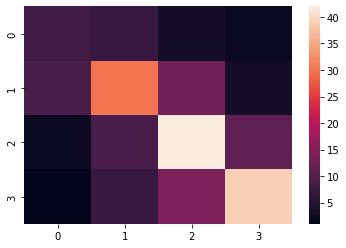

In [9]:
c = pyanno.measures.agreement.confusion_matrix(anno.annotations[:,0], anno.annotations[:,1],4)
print(c)
ac = seaborn.heatmap(c)
plt.show()

Scott's $\pi$ is computed as:

$\pi = \frac{\text{Pr}(a)-\text{Pr}(e)}{1-\text{Pr}(e)}$

Where Pr($a$) is relative observed agreement, and Pr($e$) is expected agreement using joint proportions calculated from the confusion matrix or matrix of coded agreements between any two coders:

In [10]:
scotts_pi(anno.annotations[:,0], anno.annotations[:,1])

0.4386478265891502

The generalization of Scott's $\pi$ to $n$ coders is Fleiss' $\kappa$ (Fleiss called it $\kappa$ because he thought he was generalizing Cohen's $\kappa$)

In [11]:
fleiss_kappa(anno.annotations[::])

0.40417653771912765

Krippendorff's $\alpha$ generalizes of Fleiss' $\kappa$ to $n$ coders and takes into account the fact that annotations here are not categorically different, but ordinal, by adding a weight matrix in which off-diagonal cells contain weights indicating the seriousness of the disagreement between each score. When produced with no arguments, it simply produces an arithmetic distance (e.g., 3-1=2), such that cells one off the diagonal are weighted 1, two off 2, etc.

In [12]:
krippendorffs_alpha(anno.annotations[::])

0.6472588223831547

Like Scott's $\pi$, Cohen's $\kappa$ also takes into account the possibility of the agreement occurring by chance, but in the following way:

$\kappa = \frac{p_o-p_e}{1-p_e}=1-\frac{1-p_o}{p_e}$

where $p_o$ is the relative observed agreement among raters, and $p_e$ is the hypothetical probability of chance agreement, using the observed data to calculate the probabilities of each observer randomly saying each category. If the raters are in complete agreement then $\kappa = 1$. If there is no agreement among the raters other than what would be expected by chance (as given by $p_e$), $\kappa ≤ 0 $. Here, Cohen's $\kappa$ statistic for the first two annotators is computed. This is probably the most common metric of agreement.

In [13]:
cohens_kappa(anno.annotations[:,0], anno.annotations[:,1])

0.43917037219392857

In [14]:
m = pairwise_matrix(cohens_kappa, anno.annotations)
print(m)

[[1.         0.43917037 0.47677621        nan        nan        nan
  0.45819119 0.43381462]
 [0.43917037 1.         0.38432922 0.41344423        nan        nan
         nan 0.33643611]
 [0.47677621 0.38432922 1.         0.39583333 0.51704894        nan
         nan        nan]
 [       nan 0.41344423 0.39583333 1.         0.34597068 0.4446844
         nan        nan]
 [       nan        nan 0.51704894 0.34597068 1.         0.37938644
  0.43039733        nan]
 [       nan        nan        nan 0.4446844  0.37938644 1.
  0.38341929 0.31214748]
 [0.45819119        nan        nan        nan 0.43039733 0.38341929
  1.         0.394806  ]
 [0.43381462 0.33643611        nan        nan        nan 0.31214748
  0.394806   1.        ]]


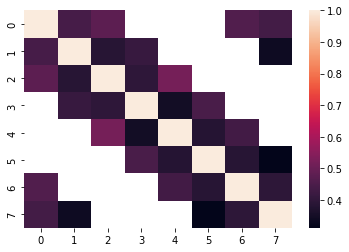

In [15]:
ax = seaborn.heatmap(m)
plt.show()

You can see that this 8 by 3 loop design will be less stable than an 8 choose 3 combinatorial design, because each codes with more others.

One can also assess the average Cohen's $\kappa$ for all pairs of coders that have coded against one another:

In [6]:
def pairwise_metric_average(metric, array):
    """Calculate the pairwise metric average for the real elements of metric function run on an array of annotations"""
    p = permutations(range(array[0,:].size),2)
    m = [metric(array[:,x[0]], array[:,x[1]]) for x in p]
    clean_m = [c for c in m if not math.isnan(c)]
    return reduce(lambda a, b: a + b, clean_m)/len(clean_m)

pairwise_metric_average(cohens_kappa, anno.annotations)

0.40911598940065674

As recognized with Krippendorff's flexible $\alpha$, our scores are *not* categorical, but rather ordered and her considered metric. Weighted $\kappa$ allows you to count disagreements differently and is useful when codes are ordered as they are here. Here a weight matrix is added to the calculation, in which off-diagonal cells contain weights indicating the seriousness of the disagreement between each score. When automatically produced, it simply produces an arithmetic distance (e.g., 3-1=2), such that cells one off the diagonal are weighted 1, two off 2, etc. Here

$\kappa = 1-\frac{\sum^k_{i=1}\sum^k_{j=1}w_{ij}x_{ij}}{\sum^k_{i=1}\sum^k_{j=1}w_{ij}m_{ij}}$

where $\kappa$ = $n$ codes and $w_{ij}$,$x_{ij}$, and $m_{ij}$ represent elements in the weight, observed, and expected matrices, respectively. (Obviously, when diagonal cells contain weights of 0 and off-diagonal cells weights of 1, this equals $\kappa$).

In [17]:
cohens_weighted_kappa(anno.annotations[:,0], anno.annotations[:,1])

0.5330240507874497

Or averaged over the total:

In [18]:
pairwise_metric_average(cohens_weighted_kappa,anno.annotations)

0.5299113458717166

Alternatively, if the annontation data can be understood as indicating real values, we can assess not agreement, but rather the correlation of values (Pearson's $\rho$) or correlation of ranks (Spearman's $\rho$) for pairs of coders:

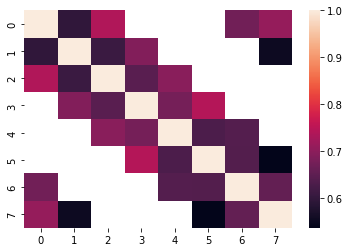

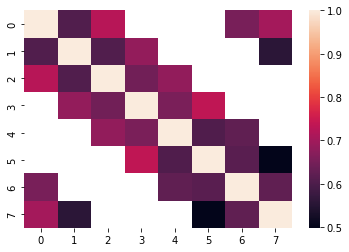

In [19]:
n = pairwise_matrix(pearsons_rho, anno.annotations)
m = pairwise_matrix(spearmans_rho, anno.annotations)
an = seaborn.heatmap(n)
plt.show()
am = seaborn.heatmap(m)
plt.show()

Or averaged over all comparable pairs:

In [20]:
print(pairwise_metric_average(pearsons_rho,anno.annotations), pairwise_metric_average(spearmans_rho,anno.annotations))

0.6517219321175077 0.63808488688039


## <font color="red">*Exercise 1*</font>

<font color="red">Perform a content annotation survey of some kind in which at least 3 people evaluate and code each piece of content, using Amazon Mechanical Turk as described in the [MTurk slides on Canvas](https://canvas.uchicago.edu/courses/54694/files/folder/unfiled?preview=10675152), or by hand with friends.  With the resulting data, calculate, visualize and discuss inter-coder agreement or covariation with appropriate metrics. What does this means for the reliability of human assessments regarding content in your domain?

In [7]:
abc_path = '/Users/itsyuzhou/Winter2024/MA_thesis/youtube_comments/comments/abc_2020'
abc_files = [f for f in os.listdir(abc_path) if f.endswith('.csv')]
monthly_data = []

for file in abc_files:
    file_path = os.path.join(abc_path, file)
    df = pd.read_csv(file_path)
    month_code = file[5:7]
    df['Video PublishedAt'] = month_code
    monthly_data.append(df)

abc_df = pd.concat(monthly_data, ignore_index=True)
abc_df = abc_df.drop(columns=['PublishedAt'])
# abc_df = abc_df.groupby('Video PublishedAt')['Comment'].apply(' '.join).reset_index()

abc_df.head()

,Comment,Video PublishedAt
0,Yep he said it a no-brainer alright,12
1,Whos sean penn?,12
2,"<a href=""about:invalid#zCSafez""></a>",12
3,Sean Penn is an enemy to the people. Cabal,12
4,2 years on - now is the time for all these &#3...,12


In [30]:
from langdetect import detect

def is_english_and_long(comment):
    try:
        is_long = len(comment.split()) > 5
        is_english = detect(comment) == 'en'
        return is_english and is_long
    except Exception:
        return False

filtered_df = abc_df[abc_df['Comment'].apply(is_english_and_long)]
selected_comments = filtered_df.sample(n=min(100, len(filtered_df)), random_state=1)['Comment'].tolist()
selected_comments

['It’s cause Trump and apparently Obama made it harder for these tests to be conducted. Or so I heard I can’t fact check it but Trump DID cut the CDC’s budget so it’s easy to believe.',
 '@@beardeddragonhq8998 and? Tax the rich more.',
 'Oh it&#39;s not ending, the trouble is only beginning, we have a very long way to go before HE is ready to end this evil corrupt world for the NEW WORLD.',
 'As in anxiety not being able to play games or watch YouTube videos instead of being outdoors',
 'are we gonna talk about how he pronounced Iran? &quot;Ihrahn&quot;<br>I want him fired.',
 'I wish I had your optimism.',
 'I have yet to see anybody in the US spraying thr public streets',
 'Even India (Kerala ) also better alert against virus , Kerala strategy they tracking  and root map of all the patients. Who deal with the patient all are under <a href="http://observation.you/">observation.you</a> must understand very think population is there in Kerala (India ). 50 percent of people abroad and tr

I will use [1,2,3,4,5,6] to represent labels ['sadness', 'irony', 'fear', 'anger','neutral', 'joy']


In [33]:
df = pd.DataFrame(selected_comments, columns=["Comment"])
df['Sentiment'] = ''
filename = "samples.csv"
df.to_csv(filename, index=False)

In [12]:
labels = ['sadness', 'irony', 'fear', 'anger','neutral', 'joy']
sentiment_mapping = {
    'sadness': 1,
    'irony': 2,
    'fear': 3,
    'anger': 4,
    'neutral': 5,
    'joy': 6
}
mapped_labels = [sentiment_mapping[label] for label in labels]

In [18]:
df1 = pd.read_csv('/Users/itsyuzhou/Winter2024/Content-Analysis-Homework/notebooks/week5/samples_yuzhou.csv')
df2 = pd.read_csv('/Users/itsyuzhou/Winter2024/Content-Analysis-Homework/notebooks/week5/samples_ryan.csv')
df3 = pd.read_csv('/Users/itsyuzhou/Winter2024/Content-Analysis-Homework/notebooks/week5/samples_ruoyi.csv')

labels1 = df1['Sentiment'].str.lower()
labels2 = df2['Sentiment'].str.lower()
labels3 = df3['Sentiment'].str.lower()

mapped_labels1 = [sentiment_mapping[label] for label in labels1]
mapped_labels2 = [sentiment_mapping[label] for label in labels2]
mapped_labels3 = [sentiment_mapping[label] for label in labels3]

df_labels = pd.DataFrame({
    'Label1': mapped_labels1,
    'Label2': mapped_labels2,
    'Label3': mapped_labels3
})
df_labels.to_csv("labeled_samples.txt", index=False, sep='\t', header=False)

In [20]:
x = np.loadtxt("/Users/itsyuzhou/Winter2024/Content-Analysis-Homework/notebooks/week5/labeled_samples.txt")
anno = AnnotationsContainer.from_array(x, missing_values=[-1])

In [22]:
anno.missing_values

[]

Calculate, visualize and discuss inter-coder agreement or covariation with appropriate metrics

In [23]:
fleiss_kappa(anno.annotations[::])

0.35393512243607117

Fleiss' Kappa of 0.3539 suggests fair agreement among raters, but it's not strong.

In [24]:
krippendorffs_alpha(anno.annotations[::])

0.23306417522264644

A Krippendorff's Alpha of 0.2330 indicates fair agreement among raters, which suggests that the agreement is somewhat better than chance but is still considered relatively low. These results suggest that while there is some consistency in how annotators are categorizing or coding the data, a significant portion of variability is not explained by a shared standard among raters. This makes sense as all of the annotators report that the comments were complex in sentiment and the clear-cut categories might not well fit.

In [25]:
m = pairwise_matrix(cohens_kappa, anno.annotations)
print(m)

[[1.         0.31216931 0.43110864]
 [0.31216931 1.         0.33342221]
 [0.43110864 0.33342221 1.        ]]


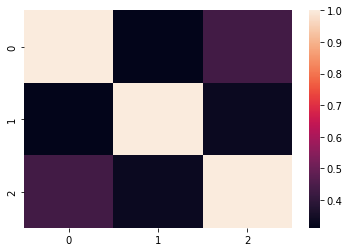

In [26]:
ax = seaborn.heatmap(m)
plt.show()

Based on the above calculation and heat map visualization, we see that the agreements among coders are generally low, less than 0.5. This means in the domain of social media and explicit attitudes toward covid-related news, the task of sentiment labeling can be relatively challenging.

# Simple Simulated Examples for Classification

Here we create a sandbox for you to explore different types of classified data and how different statistical classifiers perform on each type.

## Generating example data

We start by loading one of the "cartoon" or simplified data sets and then dividing it into training and testing sets. To maximize our ability to visualize, each dataset involves two classes, colored yellow and blue, arrayed along two dimensions (`x` and `y`).

The four data patterns include:
+ `random` in which the two classes are randomly distributed across both dimensions
+ `andSplit` in which the two classes are linearly split along one of two dimensions (e.g., men like Adidas)
+ `xorSplit` in which the two classes are split, oppositely, along each dimension (e.g., old ladies and young men like Nikes)
+ `targetSplit` in which one class is nested within the other in two dimensions (e.g., middle aged, middle income people like vintage Mustangs)
+ `multiBlobs` in which 5 classes are placed as bivariate Gaussians at random locations

`noise` is a variable [0-1] that ranges from no noise in the prescribed pattern [0] to complete noise/randomness [1].

Uncomment (remove the # in front of) each dataset, one at a time, and then run the cell and subsequent cells to examine how each machine learning approach captures each pattern.

We use the popular `train_test_split()` function from `sklearn`, and the data pattern function source code is copied below for your convenience from `lucem_illud`'s [cartoons.py](https://github.com/UChicago-Computational-Content-Analysis/lucem_illud/blob/main/lucem_illud/cartoons.py) file.

In [66]:
def random(numPerCategory = 500):
    datDict = {
        'vect' : [np.random.rand(2) * 2 - 1 for i in range(2 * numPerCategory)],
        'category' : [i % 2 for i in range(2 * numPerCategory)],
    }

    return pd.DataFrame(datDict)

def andSplit(noise = 0, numPerCategory = 500):
    def genPoint(cat):
        y = np.random.random_sample() * 2 - 1
        if noise >= 0:
            x = np.random.random_sample() - cat - (np.random.random_sample() - cat) * noise
        else:
            x = (1 - noise * np.random.random_sample()) - cat
        return np.array([x, y])
    datDict = {
        'vect' : [genPoint(i % 2) for i in range(2 * numPerCategory)],
        'category' : [i % 2 for i in range(2 * numPerCategory)],
    }

    return pd.DataFrame(datDict)

def xorSplit(noise = 0, numPerCategory = 500):
    def genPoint(cat):
        if cat == 1:
            if np.random.randint(0,2) < 1:
                y = np.random.random_sample() - np.random.random_sample() * noise * 2
                x = np.random.random_sample() - np.random.random_sample() * noise * 2
            else:
                y = np.random.random_sample() - 1 - np.random.random_sample() * noise * 2
                x = np.random.random_sample() - 1 - np.random.random_sample() * noise * 2
        else:
            if np.random.randint(0,2) < 1:
                y = np.random.random_sample() - 1 - np.random.random_sample() * noise * 2
                x = np.random.random_sample() - np.random.random_sample() * noise * 2
            else:
                y = np.random.random_sample() - np.random.random_sample() * noise * 2
                x = np.random.random_sample() - 1 - np.random.random_sample() * noise * 2
        return np.array([x, y])

    datDict = {
        'vect' : [genPoint(i % 2) for i in range(2 * numPerCategory)],
        'category' : [i % 2 for i in range(2 * numPerCategory)],
    }

    return pd.DataFrame(datDict)

def targetSplit(noise = 0, numPerCategory = 500, innerRad = .3):
    def genPoint(cat):
        if cat == 0:
            r = np.random.random_sample() * innerRad + (1 - innerRad) * np.random.random_sample() * noise
        else:
            r = np.random.random_sample() * (1 - innerRad) + innerRad - innerRad * np.random.random_sample() * noise
        eta = 2 * np.pi * np.random.random_sample()
        return np.array([r * np.cos(eta), r * np.sin(eta)])

    datDict = {
        'vect' : [genPoint(i % 2) for i in range(2 * numPerCategory)],
        'category' : [i % 2 for i in range(2 * numPerCategory)],
    }

    return pd.DataFrame(datDict)

def multiBlobs(noise = 0, numPerCategory = 500, centers = 5):
    if isinstance(centers, int):
        n_samples = numPerCategory * centers
    else:
        n_samples = numPerCategory * len(centers)
    X, y = sklearn.datasets.make_blobs(n_samples=n_samples, centers=centers, cluster_std = (.8 * (noise * 2 + 1)))
    datDict = {
        'vect' : list(X),
        'category' : y,
    }
    return pd.DataFrame(datDict)

### Generate 10 distinct artificial datasets

In [153]:
noise = .2

#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.random(noise), test_size=.2)
# dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.andSplit(noise), test_size=.2)
# dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.xorSplit(noise), test_size=.2)
# dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.targetSplit(noise), test_size=.2)
dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.multiBlobs(noise), test_size=.2)

We can easily visualize the rendered datasets because they are generated in two dimensions.

Let's see what dfTrain, a simulated data that we just made, looks like

In [68]:
dfTrain.head()

,vect,category
104,"[0.23337164920389, 0.2426075870614357]",0
287,"[-0.5837170920132493, -0.17128675364509394]",1
432,"[0.07658290785930438, 0.06737052558549617]",0
360,"[0.6230522732300678, -0.6253607603165174]",0
568,"[0.08036100035498547, 0.5826959794482729]",0


So, dfTrain has two columns, vect and category. We can plot this with `plotter()` from [lucem_illud/lucem_illud/cartoons.py](https://github.com/UChicago-Computational-Content-Analysis/lucem_illud/blob/main/lucem_illud/cartoons.py). Here's the source code:

In [31]:
def plotter(df):
    fig, ax = plt.subplots(figsize = (10,10))
    pallet = seaborn.color_palette(palette='rainbow', n_colors= len(set(df['category'])))
    for i, cat in enumerate(set(df['category'])):
        a = np.stack(df[df['category'] == cat]['vect'])
        ax.scatter(a[:,0], a[:, 1], c = pallet[i], label = cat)
    ax.legend(loc = 'center right', title = 'Categories')
    ax.axis('off')
    plt.show()
    plt.close()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


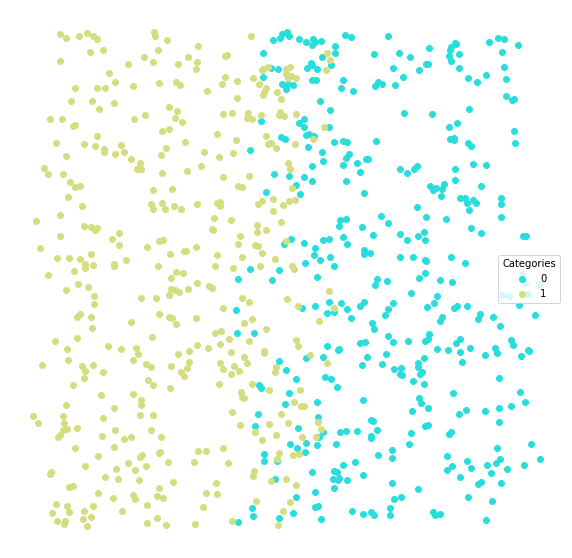

In [69]:
lucem_illud.plotter(dfTrain)

## Training a Machine Learning algorithm

We can now pick a model, there are many more options in `scikit-learn`. These are just a few examples, which array along the machine learning "tribes" described in Pedro Domingos _The Master Algorithm_.

Uncomment (remove the # in front of) each algorithm one at a time, then run the cell and subsequent cells to evaluate how it learns to understand the data.

In [175]:
from sklearn.naive_bayes import GaussianNB

#Bayes
# clf = sklearn.naive_bayes.GaussianNB()

#Analogizes
# clf = sklearn.svm.SVC(kernel = 'linear', probability = False) #slow, set probability = False to speed up
# clf = sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = True) #slower
# clf = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')# k, 'distance' or 'uniform'

#Classical Regression
# clf = sklearn.linear_model.LogisticRegression()

#Symbolists
# clf = sklearn.tree.DecisionTreeClassifier()
# clf = sklearn.ensemble.RandomForestClassifier()

#Connectionists
# clf = sklearn.neural_network.MLPClassifier()

#Ensemble
clf = sklearn.ensemble.GradientBoostingClassifier()

We're using sklearn here. What is sklearn? It's an open source machine learning library for Python. We use sklearn because it features various machine learning algorithms and it works well with NumPy library. You don't need to understand the sklearn package in detail for the moment, but let's see what methods and attributes sklearn has, because we're going to use some of them:

In [ ]:
dir(sklearn)

Now we fit the model by giving it our training data

In [176]:
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])

GradientBoostingClassifier()

Here, "stack" function is used. Why did we use stack function here? This is because dfTrain['vect'] is a sequence, while clf.fit() takes an array element. Let's see what dfTrain['vect'] looks like:

In [74]:
dfTrain['vect']

104          [0.23337164920389, 0.2426075870614357]
287     [-0.5837170920132493, -0.17128675364509394]
432      [0.07658290785930438, 0.06737052558549617]
360       [0.6230522732300678, -0.6253607603165174]
568       [0.08036100035498547, 0.5826959794482729]
                           ...                     
282      [-0.02475608138857331, 0.8490138585377447]
852        [0.3572367489172167, 0.7958915473327448]
905      [-0.6088731063527628, -0.6459928401963835]
123    [-0.37976406992138523, -0.39117465918725514]
22      [0.9116880009652831, -0.015082764951536598]
Name: vect, Length: 800, dtype: object

And let's see what np.stack(dfTrain['vect']) does:

In [86]:
np.stack(dfTrain['vect'])

array([[ 0.23337165,  0.24260759],
       [-0.58371709, -0.17128675],
       [ 0.07658291,  0.06737053],
       ...,
       [-0.60887311, -0.64599284],
       [-0.37976407, -0.39117466],
       [ 0.911688  , -0.01508276]])

As you can see, stack function takes a sequence of arrays (which have the same shape) and joins them along a new axis.

## Algorithm evaluation

We can look at few measurements of each classifier's performance by using the testing set. These `lucem_illud` functions are in [metrics.py](https://github.com/UChicago-Computational-Content-Analysis/lucem_illud/blob/main/lucem_illud/metrics.py), and we will skip copying source code this time due to length.

## 1. andSplit

In [76]:
# andSplit & Gaussian NB (Bayes)
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.09,0.910172,0.925234,0.890350,0.908257
1,0.09,0.910172,0.892473,0.854014,0.912088


In [83]:
# andSplit & SVC(kernel='linear')
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.09,0.91108,0.933333,0.894144,0.899083
1,0.09,0.91108,0.884211,0.851194,0.923077


In [87]:
# andSplit & SVC(kernel='poly', probability=True)
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.1,0.906442,0.978495,0.906908,0.834862
1,0.1,0.906442,0.831776,0.823495,0.978022


In [90]:
# andSplit & KNeighborsClassifier(weights='distance')
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.1,0.900998,0.923810,0.882106,0.889908
1,0.1,0.900998,0.873684,0.836877,0.912088


In [93]:
# andSplit & LogisticRegression()
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.095,0.905585,0.924528,0.886227,0.899083
1,0.095,0.905585,0.882979,0.845354,0.912088


In [96]:
# andSplit & DecisionTreeClassifier()
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.115,0.886329,0.913462,0.866136,0.871560
1,0.115,0.886329,0.854167,0.814689,0.901099


In [99]:
# andSplit & RandomForestClassifier()
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.08,0.920254,0.934579,0.902412,0.917431
1,0.08,0.920254,0.903226,0.868747,0.923077


In [102]:
# andSplit & MLPClassifier()
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.095,0.906493,0.932692,0.890011,0.889908
1,0.095,0.906493,0.875000,0.842692,0.923077


In [105]:
# andSplit & GradientBoostingClassifier()
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.1,0.902813,0.940594,0.889784,0.871560
1,0.1,0.902813,0.858586,0.831976,0.934066


## 2. xorSplit

In [109]:
# xorSplit & Gaussian NB (Bayes)
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.535,0.477254,0.442748,0.449124,0.630435
1,0.535,0.477254,0.507246,0.529385,0.324074


In [112]:
# xorSplit & SVC(kernel='linear')
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.32,0.662641,0.759259,0.593366,0.445652
1,0.32,0.662641,0.650685,0.637362,0.879630


In [115]:
# xorSplit & SVC(kernel='poly', probability=True)
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.335,0.653583,0.681159,0.572984,0.510870
1,0.335,0.653583,0.656489,0.632759,0.796296


In [118]:
# xorSplit & KNeighborsClassifier(weights='distance')
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.125,0.873792,0.868132,0.810461,0.858696
1,0.125,0.873792,0.880734,0.842875,0.888889


In [121]:
# xorSplit & LogisticRegression()
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.54,0.467794,0.433333,0.444928,0.565217
1,0.54,0.467794,0.500000,0.525185,0.370370


In [124]:
# xorSplit & DecisionTreeClassifier()
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.11,0.891707,0.857143,0.822609,0.913043
1,0.11,0.891707,0.921569,0.872106,0.870370


In [127]:
# xorSplit & RandomForestClassifier()
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.115,0.883857,0.879121,0.824453,0.869565
1,0.115,0.883857,0.889908,0.854269,0.898148


In [130]:
# xorSplit & MLPClassifier()
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.115,0.886272,0.855670,0.816963,0.902174
1,0.115,0.886272,0.912621,0.864319,0.870370


In [133]:
# xorSplit & GradientBoostingClassifier()
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.125,0.877013,0.838384,0.801368,0.902174
1,0.125,0.877013,0.910891,0.855944,0.851852


## 3. targetSplit

In [137]:
# targetSplit & Gaussian NB (Bayes)
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.05,0.950095,0.940594,0.92259,0.959596
1,0.05,0.950095,0.959596,0.93259,0.940594


In [140]:
# targetSplit & SVC(kernel='linear')
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.325,0.677618,0.611842,0.604761,0.939394
1,0.325,0.677618,0.875000,0.658861,0.415842


In [143]:
# targetSplit & LogisticRegression()
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.485,0.514901,0.510204,0.502679,0.505051
1,0.485,0.514901,0.519608,0.512666,0.524752


In [146]:
# targetSplit & RandomForestClassifier()
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.105,0.894839,0.906250,0.856402,0.878788
1,0.105,0.894839,0.884615,0.850788,0.910891


In [149]:
# targetSplit & MLPClassifier()
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.07,0.930093,0.920792,0.894986,0.939394
1,0.07,0.930093,0.939394,0.904986,0.920792


In [152]:
# targetSplit & GradientBoostingClassifier()
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.09,0.910091,0.900990,0.868183,0.919192
1,0.09,0.910091,0.919192,0.878183,0.900990


## 4. multiBlobs

In [156]:
# multiBlobs & Gaussian NB
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.000,1.000000,1.000000,1.000000,1.000000
1,0.000,1.000000,1.000000,1.000000,1.000000
2,0.006,0.992543,0.980392,0.972685,0.990099
3,0.006,0.989783,0.990991,0.977295,0.982143
4,0.000,1.000000,1.000000,1.000000,1.000000


In [159]:
# multiBlobs & SVC(kernel='linear')
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.000,1.000000,1.000000,1.000000,1.000000
1,0.000,1.000000,1.000000,1.000000,1.000000
2,0.006,0.992543,0.980392,0.972685,0.990099
3,0.006,0.989783,0.990991,0.977295,0.982143
4,0.000,1.000000,1.000000,1.000000,1.000000


In [162]:
# multiBlobs & SVC(kernel='poly', probability=True)
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.000,1.000000,1.000000,1.000000,1.000000
1,0.004,0.990826,1.000000,0.985651,0.981651
2,0.018,0.985024,0.925926,0.918758,0.990099
3,0.008,0.985318,0.990909,0.970367,0.973214
4,0.006,0.983696,1.000000,0.973391,0.967391


In [165]:
# multiBlobs & KNeighborsClassifier(weights='distance')
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.000,1.000000,1.000000,1.000000,1.000000
1,0.000,1.000000,1.000000,1.000000,1.000000
2,0.012,0.977692,0.979798,0.948994,0.960396
3,0.012,0.985917,0.964912,0.951682,0.982143
4,0.000,1.000000,1.000000,1.000000,1.000000


In [168]:
# multiBlobs & LogisticRegression()
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.000,1.000000,1.000000,1.000000,1.000000
1,0.000,1.000000,1.000000,1.000000,1.000000
2,0.006,0.992543,0.980392,0.972685,0.990099
3,0.006,0.989783,0.990991,0.977295,0.982143
4,0.000,1.000000,1.000000,1.000000,1.000000


In [171]:
# multiBlobs & RandomForestClassifier()
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.000,1.000000,1.000000,1.000000,1.000000
1,0.000,1.000000,1.000000,1.000000,1.000000
2,0.012,0.985086,0.961165,0.946132,0.980198
3,0.010,0.980854,0.990826,0.963439,0.964286
4,0.002,0.998775,0.989247,0.989247,1.000000


In [174]:
# multiBlobs & MLPClassifier()
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.000,1.000000,1.000000,1.000000,1.000000
1,0.000,1.000000,1.000000,1.000000,1.000000
2,0.006,0.992543,0.980392,0.972685,0.990099
3,0.006,0.989783,0.990991,0.977295,0.982143
4,0.000,1.000000,1.000000,1.000000,1.000000


In [177]:
# multiBlobs & GradientBoostingClassifier()
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.000,1.000000,1.000000,1.000000,1.000000
1,0.000,1.000000,1.000000,1.000000,1.000000
2,0.016,0.978883,0.951456,0.929195,0.970297
3,0.016,0.970637,0.981481,0.940902,0.946429
4,0.004,0.997549,0.978723,0.978723,1.000000


This lets us look at which classes do better:

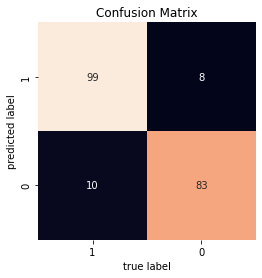

In [77]:
lucem_illud.plotConfusionMatrix(clf, dfTest)

The greater the area under the curve the better.

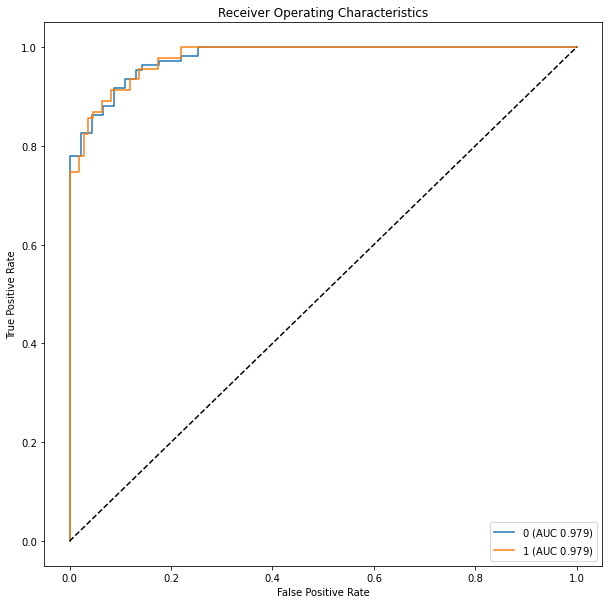

In [78]:
lucem_illud.plotMultiROC(clf, dfTest)

We can also look at the regions the classifer identifies as one class or the other:

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


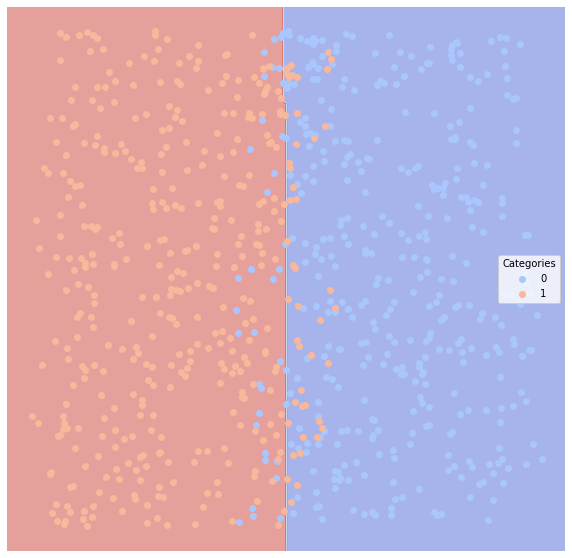

In [79]:
lucem_illud.plotregions(clf, dfTrain)

## Now we do the same for real data

Available data sets include:
+ Reddit threads "classified" by thread topic
+ 20 newsgroups "classified" by group topic
+ Senate press releases "classified" by Senator (2 senators)
+ Senate press releases "classified" by Senator (5 senators)
+ Emails classified as Spam or Ham

Note that if you're on Google Colab and have not `git clone`ed the [class repo](https://github.com/UChicago-Computational-Content-Analysis/Homework-Notebooks-2024-Winter), you can set a `dataDirectory=` parameter in the loadReddit function to match the data folder path on Colab.

In [212]:
# dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.loadReddit(dataDirectory='../data/'), test_size=.2)
# dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.loadReddit(dataDirectory='/Users/itsyuzhou/Winter2024/Content-Analysis-Homework/data'), test_size=.2)
# dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.loadNewsGroups('/Users/itsyuzhou/Winter2024/Content-Analysis-Homework/data'), test_size=.2)
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.loadSenateSmall(), test_size=.2)
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.loadSenateLarge(), test_size=.2)
dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.loadSpam(dataDirectory='/Users/itsyuzhou/Winter2024/Content-Analysis-Homework/data'), test_size=.2)

Loading Spam
Loading Ham
Converting to vectors


/Users/itsyuzhou/opt/anaconda3/lib/python3.9/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [213]:
dfTrain.head()

,category,text,is_spam,binary,tokenized_text,normalized_text,vect
1044,not spam,Sorting,False,False,[Sorting],[sorting],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
6,spam,Online Doctors will fill your Viagra Prescript...,True,True,"[Online, Doctors, will, fill, your, Viagra, Pr...","[online, doctors, fill, viagra, prescription, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2118,not spam,[Spambayes] Maybe change X-Spam-Disposition to...,False,False,"[Spambayes, Maybe, change, X, Spam, Dispositio...","[spambayes, maybe, change, x, spam, disposition]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3116,not spam,Re: storage bits,False,False,"[Re, storage, bits]","[storage, bits]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
726,not spam,Take all your music on the road (ZDNET SHOPPER),False,False,"[Take, all, your, music, on, the, road, ZDNET,...","[music, road, zdnet, shopper]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [239]:
#Classical Regression
# clf = sklearn.linear_model.LogisticRegression()

#Bayes
# clf = sklearn.naive_bayes.GaussianNB()

#Analogizes
# clf = sklearn.svm.SVC(kernel = 'linear', probability = True) #slow, set probability = False to speed up, but lose ROC
# clf = sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = True) #slower
# clf = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')# k, 'distance' or 'uniform'

#Symbolists
# clf = sklearn.tree.DecisionTreeClassifier()
# clf = sklearn.ensemble.RandomForestClassifier()

#Connectionists
# clf = sklearn.neural_network.MLPClassifier()

#Ensemble
clf = sklearn.ensemble.GradientBoostingClassifier()

In [240]:
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])

GradientBoostingClassifier()

## 1. Email Spam

In [219]:
# Spam & LogisticRegression()
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
not spam,0.109489,0.630098,0.890244,0.890074,0.994889
spam,0.109489,0.630098,0.896552,0.342970,0.265306


In [216]:
# Spam & GaussianNB
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
not spam,0.135766,0.840029,0.964286,0.950752,0.873935
spam,0.135766,0.840029,0.516340,0.443970,0.806122


In [223]:
# Spam & SVC (linear)
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
not spam,0.084672,0.759335,0.927302,0.925744,0.977853
spam,0.084672,0.759335,0.803030,0.499985,0.540816


In [226]:
# Spam & SVC (poly)
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
not spam,0.077372,0.738092,0.919811,0.919597,0.996593
spam,0.077372,0.738092,0.959184,0.534469,0.479592


In [229]:
# Spam & KNN
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
not spam,0.091971,0.704073,0.910658,0.910109,0.989779
spam,0.091971,0.704073,0.872340,0.448170,0.418367


In [232]:
# Spam & DT
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
not spam,0.083212,0.802689,0.941667,0.938491,0.962521
spam,0.083212,0.802689,0.741176,0.527565,0.642857


In [235]:
# Spam & RF
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
not spam,0.072993,0.808652,0.942339,0.940157,0.974446
spam,0.072993,0.808652,0.807692,0.570326,0.642857


In [238]:
# Spam & MLP
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
not spam,0.074453,0.824801,0.948161,0.945052,0.965928
spam,0.074453,0.824801,0.770115,0.571763,0.683673


In [241]:
# Spam & GradientBoostingClassifier
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
not spam,0.108029,0.6437,0.894009,0.893693,0.991482
spam,0.108029,0.6437,0.852941,0.353131,0.295918


## 2. Reddit

In [182]:
# Reddit & LogisticRegression()
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
Bad Roommates,0.009375,0.988942,0.972222,0.961654,0.985915
Tales From Tech Support,0.006250,0.992218,0.988764,0.980779,0.988764
Weeaboo Tales,0.000000,1.000000,1.000000,1.000000,1.000000
Relationships,0.009375,0.984454,0.986301,0.965895,0.972973


In [185]:
# Reddit & GaussianNB
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
Bad Roommates,0.112500,0.791787,0.830189,0.598858,0.619718
Tales From Tech Support,0.059375,0.900165,0.972973,0.840249,0.808989
Weeaboo Tales,0.203125,0.857434,0.570470,0.566961,0.988372
Relationships,0.137500,0.735772,0.840909,0.536080,0.500000


In [188]:
# Reddit & SVC (linear)
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
Bad Roommates,0.009375,0.983907,0.985714,0.964198,0.971831
Tales From Tech Support,0.003125,0.997835,0.988889,0.988889,1.000000
Weeaboo Tales,0.000000,1.000000,1.000000,1.000000,1.000000
Relationships,0.006250,0.991211,0.986486,0.976281,0.986486


In [191]:
# Reddit & SVC (poly)
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
Bad Roommates,0.021875,0.965807,0.957143,0.915719,0.943662
Tales From Tech Support,0.015625,0.982271,0.966667,0.951194,0.977528
Weeaboo Tales,0.021875,0.959302,1.000000,0.940480,0.918605
Relationships,0.028125,0.976983,0.901235,0.892181,0.986486


In [194]:
# Reddit & KNN
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
Bad Roommates,0.056250,0.893376,0.934426,0.793923,0.802817
Tales From Tech Support,0.028125,0.956345,0.976190,0.921286,0.921348
Weeaboo Tales,0.068750,0.938283,0.820000,0.794360,0.953488
Relationships,0.059375,0.918864,0.866667,0.789386,0.878378


In [197]:
# Reddit & DT
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
Bad Roommates,0.062500,0.914531,0.849315,0.769780,0.873239
Tales From Tech Support,0.090625,0.871613,0.875000,0.747577,0.786517
Weeaboo Tales,0.065625,0.925711,0.857143,0.802409,0.906977
Relationships,0.043750,0.943199,0.894737,0.840941,0.918919


In [200]:
# Reddit & RF
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
Bad Roommates,0.006250,0.990950,0.985915,0.975154,0.985915
Tales From Tech Support,0.009375,0.990053,0.977778,0.969917,0.988764
Weeaboo Tales,0.006250,0.995726,0.977273,0.977273,1.000000
Relationships,0.009375,0.979730,1.000000,0.968834,0.959459


In [203]:
# Reddit & MLP
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
Bad Roommates,0.015625,0.974857,0.971429,0.939757,0.957746
Tales From Tech Support,0.003125,0.997835,0.988889,0.988889,1.000000
Weeaboo Tales,0.006250,0.992049,0.988372,0.980004,0.988372
Relationships,0.006250,0.991211,0.986486,0.976281,0.986486


In [206]:
# Reddit & GradientBoostingClassifier
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
Bad Roommates,0.021875,0.965807,0.957143,0.915719,0.943662
Tales From Tech Support,0.021875,0.981395,0.936170,0.928776,0.988764
Weeaboo Tales,0.018750,0.968793,0.987805,0.945999,0.941860
Relationships,0.025000,0.964843,0.945946,0.907314,0.945946


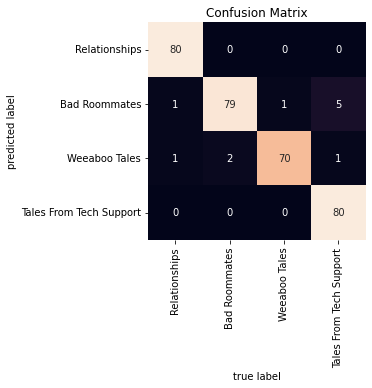

In [52]:
lucem_illud.plotConfusionMatrix(clf, dfTest)

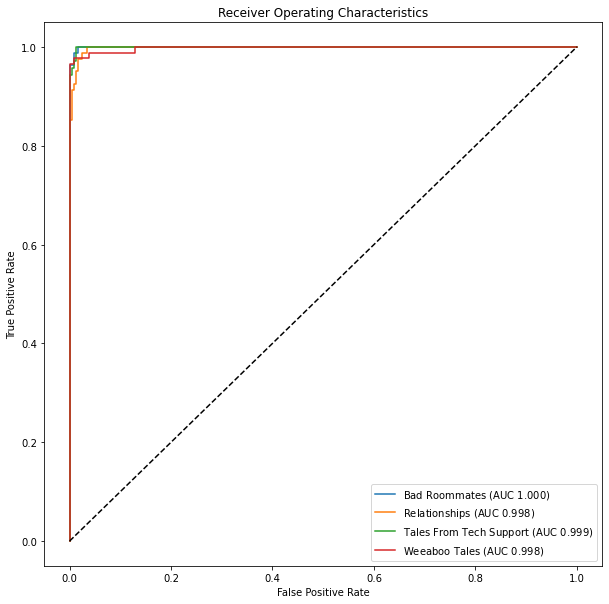

In [53]:
lucem_illud.plotMultiROC(clf, dfTest)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

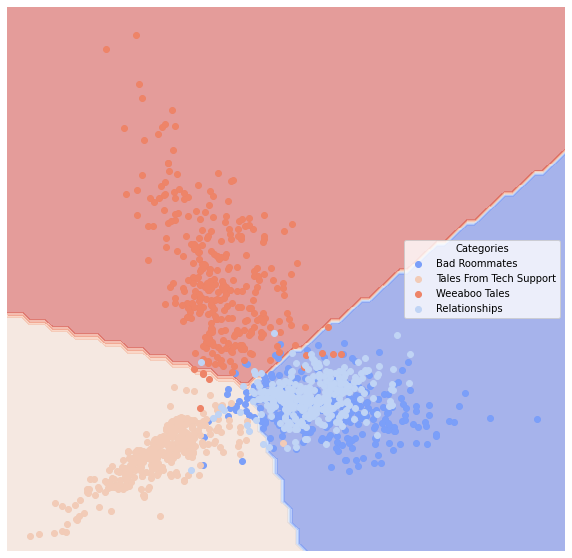

In [54]:
lucem_illud.plotregions(clf, dfTrain)

## <font color="red">*Exercise 2*</font>

<font color="red">Go back through all of the cells above and generate 10 distinct artificial datasets and classify them with all of the available methods. Add a cell immediately below and describe which classifier(s) worked best with which artificially constructed data source and why. Then go through all of the empirical datasets (i.e., Newsgroups, Senate Small, Senate Large, Email Spam) and classify them with all available methods. Add a second cell immediately below and describe which classifier(s) worked best with which data set and why.

<font color="red">***Stretch*** (but also required) Wander through the SKLearn documentation available [here](http://scikit-learn.org/stable/), particularly perusing the classifiers. In cells following, identify and implement a new classifier that we have not yet used (e.g., AdaBoost, CART) on one artificial dataset and one real dataset (used above). Then, in the next cell describe the classifier, detail how it compares with the approaches above, and why it performed better or worse than others.

Artificial Datasets:
- Using the artificial dataset of "andSplit", we see that random forest actually performs the best. This might be due to Random Forest building multiple decision trees and aggregates their results and able to capture the linear separability efficiently by considering the most informative features.

- For xorSplit dataset, both MLP and decision tree classifier did a good job with respecitive average precision around 0.82 for category 0 and 0.87 for category 1, and 0.91 recall score for category 0 and 0.87 forcategory 1. This dataset forms a pattern where categories are not linearly separable by a single line but can be separated by dividing the space into quadrants. Multilayer Perceptrons (MLPs) and Decision Trees can handle such non-linear separability well. 

- For targetSplit, Gaussian NB (Bayes) performs the best with recall score 0.96 and 0.94 for category 0 and 1 respectively. This dataset generates points in a circular or target-like distribution, with one category surrounded by another. Gaussian Naive Bayes performs well because it models the distribution of each feature in each class and can effectively handle the radial distribution if the features are somewhat normally distributed in each class. 

- For multiBlobs, all of the 10 classifier perform very well, particularly Bayes, SVC, logistic regression, and MLP all perform with nearly 1 score for average precision and recall scores. This dataset generates a dataset with multiple clusters or "blobs," potentially making the dataset have multiple distinct groups that are linearly separable or nearly so such that all classifiers tend to work well.

Real Datasets:
- Reddit data: result shows that logistic regression, SVC (linear), random forest, and MLP perform well compared to the rest. Since this dataset is more complex than the previous artificial dataset, Random Forest can also manage high-dimensional data and is capable of capturing complex interactions between features. MLP also performs well possibly because it can learn deep representations of text data, capturing nuances and patterns missed by simpler models.
- Email spam classficication: One interesting finding is that all models perform well for non-spam data but significantly worse for spam email. The findings from the email spam classification task highlight a common challenge in imbalanced classification problems, where models perform better on the majority class (non-spam) than on the minority class (spam). Among these models and only non-spam category, random forest performs the best in terms of balancing the average precision score and recall school, which are 0.940157 and 0.974446. Random forest is good at handling imbalanced data due to its ensemble nature, combining multiple decision trees to make more robust predictions. Other models such as MLP, SVC (poly), and logistic regression has extremely high recall scores but less high average precision scores. 

Stretch using Adaboost

In [348]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier

clf = AdaBoostClassifier(n_estimators=100, algorithm="SAMME",)
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])

lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
not spam,0.137226,0.520408,0.861968,0.861968,1.000000
spam,0.137226,0.520408,1.000000,0.178043,0.040816


Using Adaboost we see that not surprisingly the overall performance on non-spam is really good but not so good for spam due to potential data imbalance issue. However, Using Adaboost shows a nearly perfect performace for spam classification based on the criteria of precision, which is unique compared to other models. AdaBoost combines multiple weak learners (typically simple decision trees) to create a strong classifier. 

In [349]:
dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.targetSplit(noise), test_size=.2)

clf = AdaBoostClassifier(n_estimators=100, algorithm="SAMME",)
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])

lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.08,0.920915,0.897959,0.870643,0.93617
1,0.08,0.920915,0.941176,0.902386,0.90566


Since the previous best recall scores are 0.96 and 0.94 obtained from Gaussian NB, we see that Adaboost does not necessarily lead to a good performance.

# Clinton / Obama Press Releases

We often will not have nicely prepared data, so we will work though the proccess of cleaning and structuring in more detail here:

While the Clinton and Obama Senatorial Press Releases are not hand-coded, we can imagine that we have been given a stack of such press releases, but lost the metadata associated with which senatorial office issued which. If we label a few of them, how well can our classifier do at recovering the rest?

In [243]:
ObamaClintonReleases = pd.read_csv('/Users/itsyuzhou/Winter2024/Content-Analysis-Homework/data/ObamaClintonReleases.csv', index_col=0)

I'm pretty sure that you're all familiar with pandas, but, just to clarify: why do we use pandas here? pandas is a Python library which is widely used for analyzing and wrangling data. In particular, pandas loads data and creates data frame, a Python object that looks familiar to us (since it looks like a excel table) and easy to work with. So, using pandas.read_csv function, we take in the csv file and convert it into a data frame.

In [ ]:
type(ObamaClintonReleases)

It's a DataFrame! and it looks like this:

In [244]:
ObamaClintonReleases.head()

,download_url,html_url,name,path,text,targetSenator
0,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Apr2007Obama430.txt,raw/Obama/10Apr2007Obama430.txt,Obama Calls on IRS to Protect Taxpayers ...,Obama
1,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Apr2008Obama108.txt,raw/Obama/10Apr2008Obama108.txt,Statement from Senator Barack Obama on the ...,Obama
2,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Aug2005Obama674.txt,raw/Obama/10Aug2005Obama674.txt,Obama Says Bill Will Help Cut Off Supply of...,Obama
3,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Aug2005Obama675.txt,raw/Obama/10Aug2005Obama675.txt,Obama Durbin Say Illinois Will Receive 33 ...,Obama
4,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Aug2006Obama508.txt,raw/Obama/10Aug2006Obama508.txt,Obama Introduces Bill to Help Tap Power of ...,Obama


Neat! Let's turn the 'targetSenator' column into a binary category variable.

In [245]:
ObamaClintonReleases['category'] = [s == 'Obama' for s in ObamaClintonReleases['targetSenator']]

Tokenize and normalize

In [246]:
ObamaClintonReleases['tokenized_text'] = ObamaClintonReleases['text'].apply(lambda x: lucem_illud.word_tokenize(x))
ObamaClintonReleases['normalized_text'] = ObamaClintonReleases['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x))

/Users/itsyuzhou/opt/anaconda3/lib/python3.9/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


Let's split the data into training data and testing data.

In [248]:
holdBackFraction = .2
train_data_df, test_data_df = sklearn.model_selection.train_test_split(ObamaClintonReleases, test_size=holdBackFraction)

In [249]:
print(len(train_data_df))
print(len(test_data_df))

1367
342


## Logistic Regression

First, let's try with a logistic regression, which may be familiar to you from statistical methods classes. First, we must turn the training dataset into a tf-idf matrix (`lucem_illud.generateVecs()` will help with this but for now we are doing it the long way):

In [250]:
TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects = TFVectorizer.fit_transform(train_data_df['text'])

The core function here is TfidfVectorizer, which takes a collection of raw documents and turn them to a tf-idf matrix. Just to recap: tf-idf means term frequency-inverse document frequency, a statistic (or, more precisely, a product of two statistics, term frequency and inverse document frequency) that shows the importance of a term vis-a-vis documents. TF, or, term frequency, counts how many times a term is used in a document; IDF, or, inverse-document-frequency, measures common or rare a term appears across documents.

Let's look at three parameters of TfidfVectorizer: max_df = 100, min_df = 2, and norm='l2'. What do those parameters mean?

(1) max_df = 100

Here, we specified a thredhold of 100, and the terms that have a document frequency higher than 100 would be ignored.

(2) min_df = 2

We specified a lower bound, 2, and the terms that have a document frequency lower than 2 will be ignored.

(3) norm = 'l2'

This parameter is about vector normalization. In machine learning, we commonly normalize vectors, i.e., change the length of vectors and turn them into a unit vector, before passing them into algorithms. There are various ways of normalizations, and this parameter specifies how we normalize vectors. Here, we set the norm to l2, in which case, we normalize the vectors such that squares of vector elements sums to 1. Alternatively, we can set it to l1, in which case the sum of absolute values of vector elements, not the square of vector elements, is 1.

fit_transform() literally fits to data and then transform it. So, fit_transform() is just a combination of two steps--(1) fitting parameters to data; (2) then, using the vocabulary and document frequencies learned by fit(), transforming documents into document-term matrix. So, it's the same as fit followed by transform.

Note that we can use the CountVectorizer instead, which simply produces a matrix of word counts.

In [252]:
TFVects.shape

(1367, 11391)

We can save this in the dataframe to make things easier

In [253]:
train_data_df['vect'] = [np.array(v).flatten() for v in TFVects.todense()]

Looks simple, but we need to know what todense() does here. todense() returns a dense matrix representation of the matrix. Why do we need this? As you can see above, the TFVects, a document-term matrix, has 11349 columns, and this matrix is sparse, in the sense that it is comprised mostly of zeros. Dense matrices, in contrast, are the matrices that are comprised of mostly non-zeros. Then why do we make sparse matrices into dense ones? Because zero values don't contain important information but take up so much memory.

In a regression, we cannot have more variables than cases. So, we need to first do a dimension reduction. First, we will approah this with PCA. You have previously seen this in week 3. Here we are not concerned about visualization, but rather classification and so all principal components are calculated. Watch out: we have to use `stack` not `sum` for combining the vectors. We note that you could also use topic loading and embedding dimensions as featured variables.

In [254]:
pca = sklearn.decomposition.PCA()
reduced_data = pca.fit_transform(np.stack(train_data_df['vect'], axis=0))

We can store the PCA space vectors in the dataframe too:

In [256]:
train_data_df['pca'] = [r for r in reduced_data]

Visualization in 2D:

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


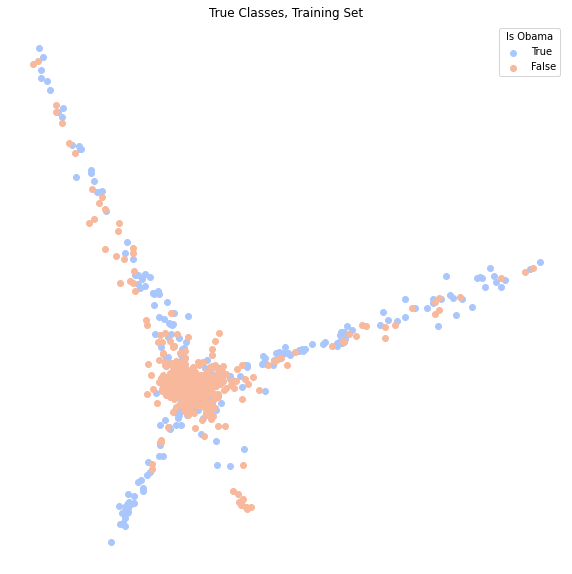

In [257]:
fig, ax = plt.subplots(figsize = (10,10))
ax.axis('off')
pallet = seaborn.color_palette(palette='coolwarm', n_colors = 2)

#Plot Obama
a = np.stack(train_data_df[train_data_df['category']]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[0], label = "True")

#Plot not Obama
a = np.stack(train_data_df[train_data_df['category'].eq(False)]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[1], label = "False")

ax.legend(loc = 'upper right', title = 'Is Obama')
plt.title('True Classes, Training Set')
plt.show()

PCA cannot distinguish Obama very well. Let's perform a screeplot to see how many Principal Components we need.

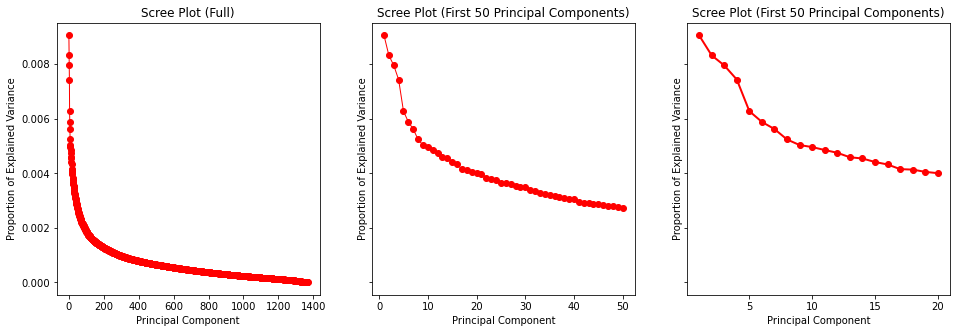

In [258]:
n = len(train_data_df)

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize = (16, 5), sharey=True)

eigen_vals = np.arange(n) + 1
ax1.plot(eigen_vals, pca.explained_variance_ratio_, 'ro-', linewidth=1)
ax1.set_title('Scree Plot (Full)')
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Proportion of Explained Variance')

eigen_vals = np.arange(50) + 1
ax2.plot(eigen_vals, pca.explained_variance_ratio_[:50], 'ro-', linewidth=1)
ax2.set_title('Scree Plot (First 50 Principal Components)')
ax2.set_xlabel('Principal Component')
ax2.set_ylabel('Proportion of Explained Variance')


eigen_vals = np.arange(20) + 1
ax3.plot(eigen_vals, pca.explained_variance_ratio_[:20], 'ro-', linewidth=2)
ax3.set_title('Scree Plot (First 50 Principal Components)')
ax3.set_xlabel('Principal Component')
ax3.set_ylabel('Proportion of Explained Variance')

plt.show()

Let's choose the first 10 pricipal components as our covariates.

In [259]:
train_data_df['pca_reduced_10'] = train_data_df['pca'].apply(lambda x: x[:10])

Now we fit a logistic regression to our data.

In [260]:
logistic = sklearn.linear_model.LogisticRegression()
logistic.fit(np.stack(train_data_df['pca_reduced_10'], axis=0), train_data_df['category'])

LogisticRegression()

Let's see how the logistic regression performs on the training dataset from which we develop the model. Unfortunately, the mean accuracy is only about 64%.

In [261]:
logistic.score(np.stack(train_data_df['pca_reduced_10'], axis=0), train_data_df['category'])

0.6664228237015362

How does it perform on the testing dataset, which we "held out" and did not use for model training? We need to repeat all the steps on the testing data, but without retraining:

In [262]:
#Create vectors
TFVects_test = TFVectorizer.transform(test_data_df['text'])
test_data_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#PCA
reduced_data_test = pca.transform(np.stack(test_data_df['vect'], axis=0))
test_data_df['pca'] = [r for r in reduced_data_test]
test_data_df['pca_reduced_10'] = test_data_df['pca'].apply(lambda x: x[:10])

#Test
logistic.score(np.stack(test_data_df['pca_reduced_10'], axis=0), test_data_df['category'])

0.6695906432748538

Slightly poorer. How about using more dimensions (40)?

In [ ]:
train_data_df['pca_reduced_40'] = train_data_df['pca'].apply(lambda x: x[:40])
test_data_df['pca_reduced_40'] = test_data_df['pca'].apply(lambda x: x[:40])

logistic.fit(np.stack(train_data_df['pca_reduced_40'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_40'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_40'], axis=0), test_data_df['category']))

Or still more (100)?

In [ ]:
train_data_df['pca_reduced_100'] = train_data_df['pca'].apply(lambda x: x[:100])
test_data_df['pca_reduced_100'] = test_data_df['pca'].apply(lambda x: x[:100])

logistic.fit(np.stack(train_data_df['pca_reduced_100'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_100'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_100'], axis=0), test_data_df['category']))

Or even more (200)!

In [ ]:
train_data_df['pca_reduced_200'] = train_data_df['pca'].apply(lambda x: x[:200])
test_data_df['pca_reduced_200'] = test_data_df['pca'].apply(lambda x: x[:200])

logistic.fit(np.stack(train_data_df['pca_reduced_200'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_200'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_200'], axis=0), test_data_df['category']))

This is becoming ridiculous (400)!

In [263]:
train_data_df['pca_reduced_400'] = train_data_df['pca'].apply(lambda x: x[:400])
test_data_df['pca_reduced_400'] = test_data_df['pca'].apply(lambda x: x[:400])

logistic.fit(np.stack(train_data_df['pca_reduced_400'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_400'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_400'], axis=0), test_data_df['category']))

Training:
0.9217264081931237
Testing:
0.8391812865497076


Increasing the number of covariates would overfit our data, and it seems that using a logistic regression, our prediction accuracy is at best about 65%. We can, however, try a logistic regression that uses the TF-IDF scores for each word, but with an L1 regularization or L1-norm loss function, which is also known as least absolute deviations (LAD), least absolute errors (LAE) or L1 penalty. It minimizes the sum of the absolute differences (S) between the target value ($Y_i$) and the estimated values ($f(x_i)$) and prunes all insignificant variables (i.e., word TF-IDF scores):

$S=\sum^n_{i=1}|y_i=f(x_i)|$

The result is a model retaining only the most individually significant features.

In [264]:
logistic_l1= sklearn.linear_model.LogisticRegression(penalty='l2')
logistic_l1.fit(np.stack(train_data_df['vect'], axis=0), train_data_df['category'])
print(logistic_l1.score(np.stack(train_data_df['vect'], axis=0), train_data_df['category']))

0.9700073152889539


Train the model using training data, and then test it on the testing data.

In [265]:
print(logistic_l1.score(np.stack(test_data_df['vect'], axis=0), test_data_df['category']))

0.8391812865497076


81% accuracy seems like the best we can get by using a logistic regression.

## <font color="red">*Exercise 3*</font>

<font color="red">In the cells immediately following, perform logistic regression classification using training, testing and uncoded (i.e., data you didn't code by hand but want to use your model on) data from texts and hand-classifications associated with your final project (e.g., these could be crowd-sourced codes gathered through Amazon Mechanical Turk in Exercise 1). Visualize the confusion matrix for training and testing sets. Calculate precision, recall, the F-measure, and AUC, then perform an ROC visualization. How do these classifiers perform? Exrapolate codes from these models to all uncoded data.


In [266]:
abc_wlabel = pd.read_csv('/Users/itsyuzhou/Winter2024/Content-Analysis-Homework/notebooks/week5/samples_yuzhou.csv')
abc_wlabel.head()

,Comment,Sentiment
0,It’s cause Trump and apparently Obama made it ...,Anger
1,@@beardeddragonhq8998 and? Tax the rich more.,Neutral
2,"Oh it&#39;s not ending, the trouble is only be...",Anger
3,As in anxiety not being able to play games or ...,Fear
4,are we gonna talk about how he pronounced Iran...,Anger


Since my goal is multi-classification task, I will perform Multinomial Logistic Regression here

In [268]:
abc_wlabel['tokenized_text'] = abc_wlabel['Comment'].apply(lambda x: lucem_illud.word_tokenize(x))
abc_wlabel['normalized_text'] = abc_wlabel['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x))

/Users/itsyuzhou/opt/anaconda3/lib/python3.9/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [279]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

# Preprocess and rncode sentiment labels
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(abc_wlabel['normalized_text'].astype('str'))
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(abc_wlabel['Sentiment'])

In [280]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [281]:
from sklearn.linear_model import LogisticRegression

# Step 3: Model Training
clf = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
clf.fit(X_train, y_train)

LogisticRegression(max_iter=1000, multi_class='multinomial')

In [284]:
from sklearn.metrics import classification_report
y_pred = clf.predict(X_test)
labels = label_encoder.transform(label_encoder.classes_)
print(classification_report(y_test, y_pred, labels=labels, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

       Anger       0.62      0.71      0.67         7
        Fear       0.00      0.00      0.00         1
       Irony       0.00      0.00      0.00         1
         Joy       0.00      0.00      0.00         1
     Neutral       0.67      0.80      0.73        10
     Sadness       0.00      0.00      0.00         0

   micro avg       0.65      0.65      0.65        20
   macro avg       0.22      0.25      0.23        20
weighted avg       0.55      0.65      0.60        20



/Users/itsyuzhou/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/itsyuzhou/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/itsyuzhou/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/itsyuzho

Instead of multi-classification, use logistic regression for binary classification to classify if a comment has an anger sentiment

In [285]:
holdBackFraction = .2
train_data_df, test_data_df = sklearn.model_selection.train_test_split(abc_wlabel, test_size=holdBackFraction)

In [286]:
TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=4, min_df=2, stop_words='english', norm='l2')
TFVects = TFVectorizer.fit_transform(train_data_df['Comment'])

In [287]:
train_data_df['vect'] = [np.array(v).flatten() for v in TFVects.todense()]
pca = sklearn.decomposition.PCA()
reduced_data = pca.fit_transform(np.stack(train_data_df['vect'], axis=0))
train_data_df['pca'] = [r for r in reduced_data]

In [289]:
train_data_df.head()

,Comment,Sentiment,tokenized_text,normalized_text,vect,pca
10,Bullshit I called it 🙋🏽‍♀️ <br>** as it came i...,Anger,"[Bullshit, I, called, it, 🙋, 🏽‍, ♀, ️, <, br, ...","[bullshit, called, 🙋, 🏽‍, ♀, ️, <, br, >, came...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.0538564966623753, -0.0969727302618122, 0.0..."
11,I hate how this virus spread to the US and I s...,Anger,"[I, hate, how, this, virus, spread, to, the, U...","[hate, virus, spread, got, to, school, work, s...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.03624202091505575, -0.05284816389979612, -..."
20,"mia No it hasn’t.And if they tell you that,it’...",Anger,"[mia, No, it, hasn’t, And, if, they, tell, you...","[mia, tell, bullcrap, think, happen, thousands...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.08516396704950897, 0.07314276498632523, -0..."
43,"129,000 deaths not enough for you? USA has th...",Anger,"[129,000, deaths, not, enough, for, you, USA, ...","[deaths, usa, worst, record, worldwide, places...","[0.4047135197796233, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.04619240925444865, -0.055091668477543, -0...."
18,Mask do nothing to protect you studies have sh...,Neutral,"[Mask, do, nothing, to, protect, you, studies,...","[mask, protect, studies, shown]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.028205467570518204, -0.022869392572789603,..."


In [290]:
train_data_df['category'] = [s == 'Anger' for s in train_data_df['Sentiment']]
train_data_df.head()

,Comment,Sentiment,tokenized_text,normalized_text,vect,pca,category
10,Bullshit I called it 🙋🏽‍♀️ <br>** as it came i...,Anger,"[Bullshit, I, called, it, 🙋, 🏽‍, ♀, ️, <, br, ...","[bullshit, called, 🙋, 🏽‍, ♀, ️, <, br, >, came...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.0538564966623753, -0.0969727302618122, 0.0...",True
11,I hate how this virus spread to the US and I s...,Anger,"[I, hate, how, this, virus, spread, to, the, U...","[hate, virus, spread, got, to, school, work, s...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.03624202091505575, -0.05284816389979612, -...",True
20,"mia No it hasn’t.And if they tell you that,it’...",Anger,"[mia, No, it, hasn’t, And, if, they, tell, you...","[mia, tell, bullcrap, think, happen, thousands...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.08516396704950897, 0.07314276498632523, -0...",True
43,"129,000 deaths not enough for you? USA has th...",Anger,"[129,000, deaths, not, enough, for, you, USA, ...","[deaths, usa, worst, record, worldwide, places...","[0.4047135197796233, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.04619240925444865, -0.055091668477543, -0....",True
18,Mask do nothing to protect you studies have sh...,Neutral,"[Mask, do, nothing, to, protect, you, studies,...","[mask, protect, studies, shown]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.028205467570518204, -0.022869392572789603,...",False


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


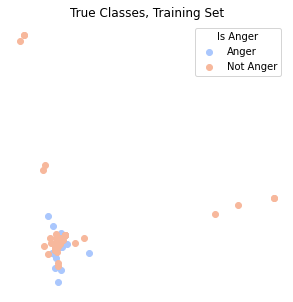

In [292]:
fig, ax = plt.subplots(figsize = (5,5))
ax.axis('off')
pallet = seaborn.color_palette(palette='coolwarm', n_colors = 2)

a = np.stack(train_data_df[train_data_df['category']]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[0], label = "Anger")

a = np.stack(train_data_df[train_data_df['category'].eq(False)]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[1], label = "Not Anger")

ax.legend(loc = 'upper right', title = 'Is Anger')
plt.title('True Classes, Training Set')
plt.show()

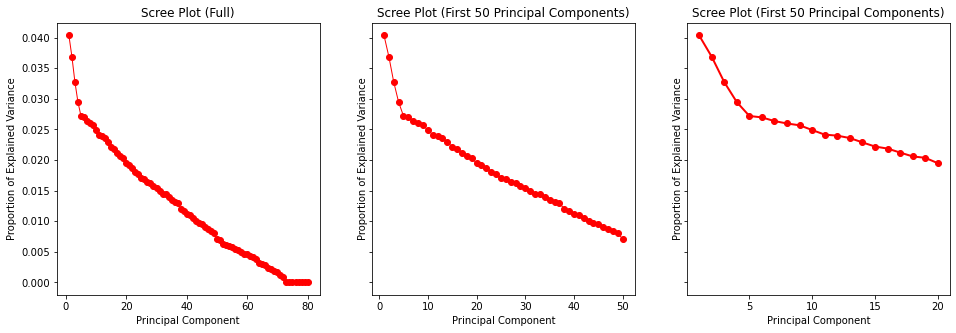

In [293]:
n = len(train_data_df)

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize = (16, 5), sharey=True)

eigen_vals = np.arange(n) + 1
ax1.plot(eigen_vals, pca.explained_variance_ratio_, 'ro-', linewidth=1)
ax1.set_title('Scree Plot (Full)')
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Proportion of Explained Variance')

eigen_vals = np.arange(50) + 1
ax2.plot(eigen_vals, pca.explained_variance_ratio_[:50], 'ro-', linewidth=1)
ax2.set_title('Scree Plot (First 50 Principal Components)')
ax2.set_xlabel('Principal Component')
ax2.set_ylabel('Proportion of Explained Variance')


eigen_vals = np.arange(20) + 1
ax3.plot(eigen_vals, pca.explained_variance_ratio_[:20], 'ro-', linewidth=2)
ax3.set_title('Scree Plot (First 50 Principal Components)')
ax3.set_xlabel('Principal Component')
ax3.set_ylabel('Proportion of Explained Variance')

plt.show()

In [294]:
train_data_df['pca_reduced_5'] = train_data_df['pca'].apply(lambda x: x[:5])
logistic = sklearn.linear_model.LogisticRegression()
logistic.fit(np.stack(train_data_df['pca_reduced_5'], axis=0), train_data_df['category'])
logistic.score(np.stack(train_data_df['pca_reduced_5'], axis=0), train_data_df['category'])

0.7

In [296]:
TFVects_test = TFVectorizer.transform(test_data_df['Comment'])
test_data_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]
test_data_df['category'] = [s == 'Anger' for s in test_data_df['Sentiment']]

reduced_data_test = pca.transform(np.stack(test_data_df['vect'], axis=0))
test_data_df['pca'] = [r for r in reduced_data_test]
test_data_df['pca_reduced_5'] = test_data_df['pca'].apply(lambda x: x[:5])

#Test
logistic.score(np.stack(test_data_df['pca_reduced_5'], axis=0), test_data_df['category'])

0.65

In [297]:
logistic_l1= sklearn.linear_model.LogisticRegression(penalty='l2')
logistic_l1.fit(np.stack(train_data_df['vect'], axis=0), train_data_df['category'])
print(logistic_l1.score(np.stack(train_data_df['vect'], axis=0), train_data_df['category']))

print(logistic_l1.score(np.stack(test_data_df['vect'], axis=0), test_data_df['category']))

0.7625
0.65


In [299]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    plt.show()

y_train_pred = logistic_l1.predict(np.stack(train_data_df['vect'], axis=0))
print(classification_report(train_data_df['category'], y_train_pred))

y_test_pred = logistic_l1.predict(np.stack(test_data_df['vect'], axis=0))
print(classification_report(test_data_df['category'], y_test_pred))

              precision    recall  f1-score   support

       False       0.74      1.00      0.85        55
        True       1.00      0.24      0.39        25

    accuracy                           0.76        80
   macro avg       0.87      0.62      0.62        80
weighted avg       0.82      0.76      0.71        80

              precision    recall  f1-score   support

       False       0.65      1.00      0.79        13
        True       0.00      0.00      0.00         7

    accuracy                           0.65        20
   macro avg       0.33      0.50      0.39        20
weighted avg       0.42      0.65      0.51        20



/Users/itsyuzhou/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/itsyuzhou/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/itsyuzhou/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


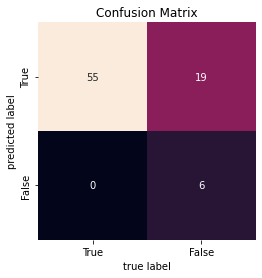

In [304]:
lucem_illud.plotConfusionMatrix(logistic_l1, train_data_df)

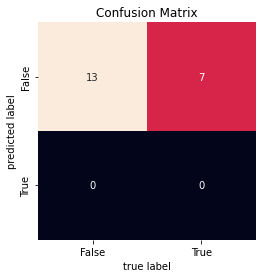

In [303]:
lucem_illud.plotConfusionMatrix(logistic_l1, test_data_df)

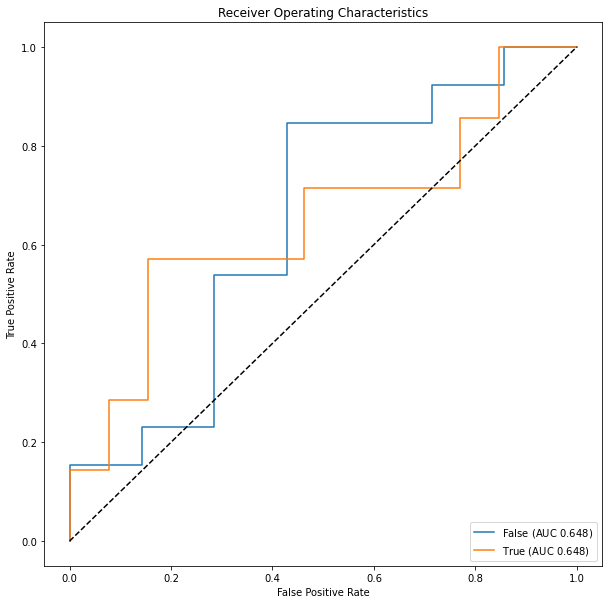

In [302]:
lucem_illud.plotMultiROC(logistic_l1, test_data_df)

Based on the above confusion matrix and AUC score, we see that for the task of classfying a comment to be either have anger sentiment or not, logistic regression works moderately with AUC score of 0.648. 

In [306]:
abc_df['tokenized_text'] = abc_df['Comment'].apply(lambda x: lucem_illud.word_tokenize(x))
abc_df['normalized_text'] = abc_df['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x))

/Users/itsyuzhou/opt/anaconda3/lib/python3.9/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [320]:
abc_df = abc_df.drop(['vect', 'pca'], axis=1)

In [323]:
# Extrapolate
extrapolate_sample = extrapolate_sample = abc_df.sample(n=138, random_state=24)

TFVects = TFVectorizer.fit_transform(extrapolate_sample['Comment'])
extrapolate_sample['vect'] = [np.array(v).flatten() for v in TFVects.todense()]
pca = sklearn.decomposition.PCA()
reduced_data = pca.fit_transform(np.stack(extrapolate_sample['vect'], axis=0))
extrapolate_sample['pca'] = [r for r in reduced_data]

In [324]:
pca_features = np.stack(extrapolate_sample['pca'], axis=0)
extrapolate_sample['Predicted_Anger'] = logistic_l1.predict(pca_features)
extrapolate_sample.head()

,Comment,Video PublishedAt,tokenized_text,normalized_text,vect,pca,Predicted_Anger
10561,"AMICII DE LA ITALIA , NOI AVEAMO PER ITALIA AN...",02,"[AMICII, DE, LA, ITALIA, NOI, AVEAMO, PER, ITA...","[amicii, de, la, italia, noi, aveamo, italia, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.00923590571434043, -0.04641583590207348, 0...",False
5170,"Eh, usa had an eejit for a leader...",03,"[Eh, usa, had, an, eejit, for, a, leader]","[eh, usa, eejit, leader]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.8984995669413874, 0.17946282644912984, -0.0...",False
487,Covid is the new Flu. No big deal. Take Nyquil,07,"[Covid, is, the, new, Flu, No, big, deal, Take...","[covid, new, flu, big, deal, nyquil]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.02985655590491582, -0.18160189720011524, -...",False
2816,ABC always the 1st in &quot;FEAR&quot; headlin...,07,"[ABC, always, the, 1st, in, quot;FEAR&quot, he...","[abc, quot;fear&quot, headlines, quot;truth&qu...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1880078175493...","[0.016459639866637493, -0.08083355139962367, -...",False
5625,I am south Korean and i think the action&amp;p...,03,"[I, am, south, Korean, and, i, think, the, act...","[south, korean, think, action&amp;prevention, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.05289853419386113, 0.0008281980394888857, ...",False


In [328]:
print(extrapolate_sample.iloc[1]['Comment'])
print(extrapolate_sample.iloc[1]['Predicted_Anger'])

Eh, usa had an eejit for a leader...
False


In [329]:
print(extrapolate_sample.iloc[5]['Comment'])
print(extrapolate_sample.iloc[5]['Predicted_Anger'])

It&#39;s a duty not to infect other people from you.
False


In [335]:
print(extrapolate_sample.iloc[21]['Comment'])
print(extrapolate_sample.iloc[21]['Predicted_Anger'])

He has mandated the vaccine. My employer says so. And I&#39;ve watched his speech. Did you not want the mandate speech? All companies with more than 100 employees must get vaccinated or they loose their jobs. So does this make him a criminal? He just said it wouldn&#39;t be legal.
False


# Decision Trees

Decision trees can be used to predict both categorical/class labels (i.e., classification) and continuous labels (i.e., regression).

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

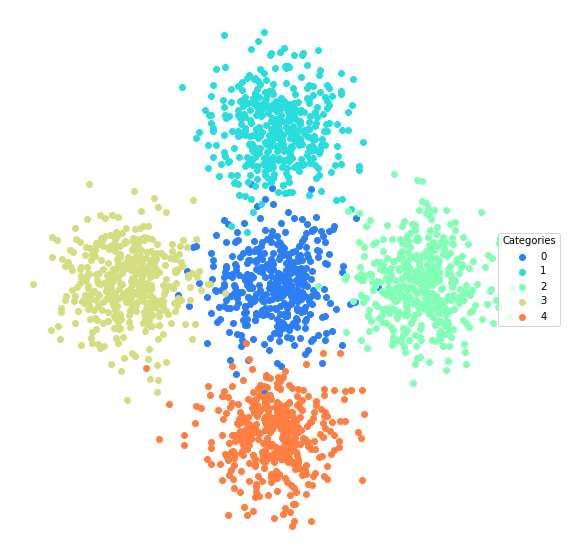

In [337]:
blobs_df = lucem_illud.multiBlobs(noise=.2, centers=[(0,0), (0,5), (5,0), (-5,0), (0,-5)])
df_exampleTree_train, df_exampleTree_test = sklearn.model_selection.train_test_split(blobs_df, test_size=.2)
lucem_illud.plotter(df_exampleTree_train)

Now we import our Decision Tree classifier from sklearn.tree (familiar syntax) and fit it using the fit method.

In [338]:
clf_tree = sklearn.tree.DecisionTreeClassifier(max_depth=4,random_state=0)
clf_tree.fit(np.stack(df_exampleTree_train['vect'], axis =0), df_exampleTree_train['category'])

DecisionTreeClassifier(max_depth=4, random_state=0)

To see what's going on visually with the classification:

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

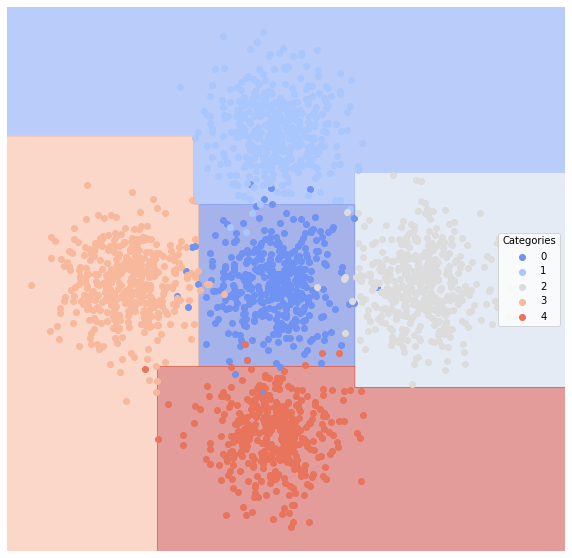

In [339]:
lucem_illud.plotregions(clf_tree, df_exampleTree_train)

In [340]:
lucem_illud.evaluateClassifier(clf_tree, df_exampleTree_test)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.024,0.970342,0.924528,0.896272,0.960784
1,0.006,0.985000,1.000000,0.976000,0.970000
2,0.006,0.987423,0.988506,0.970040,0.977273
3,0.004,0.993886,0.990291,0.982677,0.990291
4,0.008,0.988110,0.981308,0.966966,0.981308


Lets look at accuracy:

In [341]:
sklearn.metrics.accuracy_score(df_exampleTree_test['category'],clf_tree.predict(np.stack(df_exampleTree_test['vect'], axis = 0)))

0.976

What happens if we trim the tree?

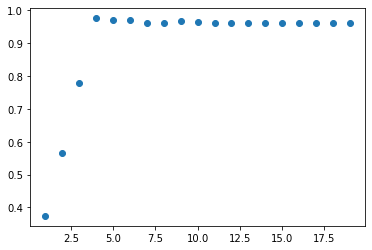

In [342]:
depthvec = []
scorevec = []
for i in range(1,20):
    tree2 = sklearn.tree.DecisionTreeClassifier(max_depth=i,random_state=0)
    tree2.fit(np.stack(df_exampleTree_train['vect'], axis =0), df_exampleTree_train['category'])
    score = sklearn.metrics.accuracy_score(df_exampleTree_test['category'], tree2.predict(np.stack(df_exampleTree_test['vect'], axis = 0)))
    depthvec.append(i)
    scorevec.append(score)
plt.scatter(depthvec,scorevec)
plt.show()

We can select different layers of the decision tree or "prune" it. At approximately four layers down in the decision tree, the shape is somewhat odd, suggesting that our model is overfitting beyond those four layers.

Combining multiple overfitting estimators turns out to be a key idea in machine learning. This is called **bagging** and is a type of **ensemble** method. The idea is to make many randomized estimators--each can overfit, as decision trees are wont to do--but then to combine them, ultimately producing a better classification. A **random forest** is produced by bagging decision trees.

In [343]:
tree = sklearn.tree.DecisionTreeClassifier(max_depth=10) #Create an instance of our decision tree classifier.

bag = sklearn.ensemble.BaggingClassifier(tree, n_estimators=100, max_samples=0.8, random_state=1) #Each tree uses up to 80% of the data

In [344]:
bag.fit(np.stack(df_exampleTree_train['vect'], axis =0), df_exampleTree_train['category']) #Fit the bagged classifier

BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=10),
                  max_samples=0.8, n_estimators=100, random_state=1)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

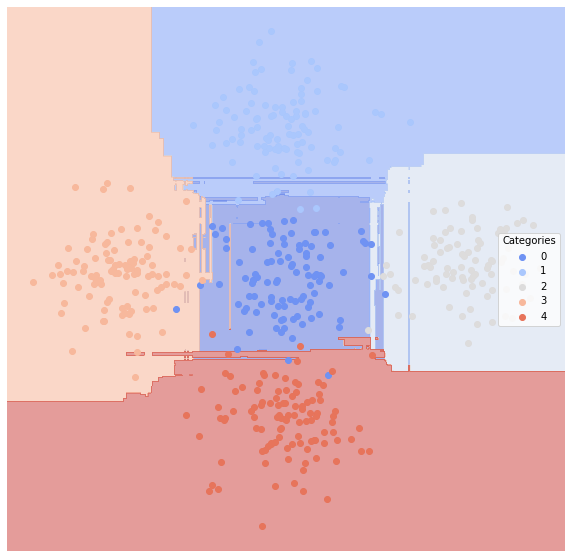

In [345]:
lucem_illud.plotregions(bag, df_exampleTree_test)

In [346]:
lucem_illud.evaluateClassifier(bag, df_exampleTree_test)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.030,0.955636,0.922330,0.873033,0.931373
1,0.008,0.983750,0.989796,0.966102,0.970000
2,0.010,0.984996,0.966292,0.948331,0.977273
3,0.002,0.998741,0.990385,0.990385,1.000000
4,0.010,0.983437,0.981132,0.959624,0.971963


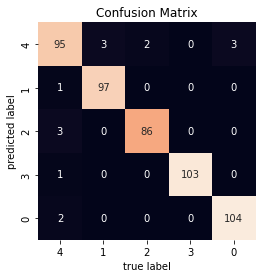

In [347]:
lucem_illud.plotConfusionMatrix(bag, df_exampleTree_test)

## <font color="red">*Exercise 4*</font>

<font color="red">In the cells immediately following, perform decision tree and random forest classification (binary, multinomial or continuous) using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project. As with ***Exercise 2***, these could be crowd-sourced codes gathered through Amazon Mechanical Turk last week. Visualize the classification of data points. Calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). Now build an ensemble classifier by bagging trees into a random forest. Visualize the result. How do these classifiers perform? What does ensemble learning do?

In [372]:
sentiment_mapping = {
    'Sadness': 1,
    'Irony': 2,
    'Fear': 3,
    'Anger': 4,
    'Neutral': 5,
    'Joy': 6
}

abc_wlabel['category'] = abc_wlabel['Sentiment'].map(sentiment_mapping)
abc_wlabel.head()

,Comment,Sentiment,tokenized_text,normalized_text,category
0,It’s cause Trump and apparently Obama made it ...,Anger,"[It, ’s, cause, Trump, and, apparently, Obama,...","[cause, trump, apparently, obama, harder, test...",4
1,@@beardeddragonhq8998 and? Tax the rich more.,Neutral,"[@@beardeddragonhq8998, and, Tax, the, rich, m...","[@@beardeddragonhq8998, tax, rich]",5
2,"Oh it&#39;s not ending, the trouble is only be...",Anger,"[Oh, it&#39;s, not, ending, the, trouble, is, ...","[oh, it&#39;s, ending, trouble, beginning, lon...",4
3,As in anxiety not being able to play games or ...,Fear,"[As, in, anxiety, not, being, able, to, play, ...","[anxiety, able, play, games, watch, youtube, v...",3
4,are we gonna talk about how he pronounced Iran...,Anger,"[are, we, gon, na, talk, about, how, he, prono...","[go, to, talk, pronounced, iran, quot;ihrahn&q...",4


In [392]:
holdBackFraction = .2
train_data_df, test_data_df = sklearn.model_selection.train_test_split(abc_wlabel, test_size=holdBackFraction)

TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=4, min_df=2, stop_words='english', norm='l2')
TFVects = TFVectorizer.fit_transform(train_data_df['Comment'])
train_data_df['vect'] = [np.array(v).flatten() for v in TFVects.todense()]
train_data_df.head()

,Comment,Sentiment,tokenized_text,normalized_text,category,vect
71,......When have we ever had control over?,Neutral,"[When, have, we, ever, had, control, over]",[control],5,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,are we gonna talk about how he pronounced Iran...,Anger,"[are, we, gon, na, talk, about, how, he, prono...","[go, to, talk, pronounced, iran, quot;ihrahn&q...",4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
27,Wear a mask and do so4cial fistancing. <br>You...,Sadness,"[Wear, a, mask, and, do, so4cial, fistancing, ...","[wear, mask, so4cial, fistancing, <, br, >, yo...",1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
37,We have to live with this we cannot close the ...,Fear,"[We, have, to, live, with, this, we, can, not,...","[live, close, country, economy, collapse, worl...",3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
79,"China is releasing virus like music album, ano...",Anger,"[China, is, releasing, virus, like, music, alb...","[china, releasing, virus, like, music, album, ...",4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [394]:
clf_tree = sklearn.tree.DecisionTreeClassifier(max_depth=4,random_state=0)
clf_tree.fit(np.stack(train_data_df['vect'], axis =0), train_data_df['category'])

DecisionTreeClassifier(max_depth=4, random_state=0)

In [396]:
TFVects_test = TFVectorizer.transform(test_data_df['Comment'])
test_data_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

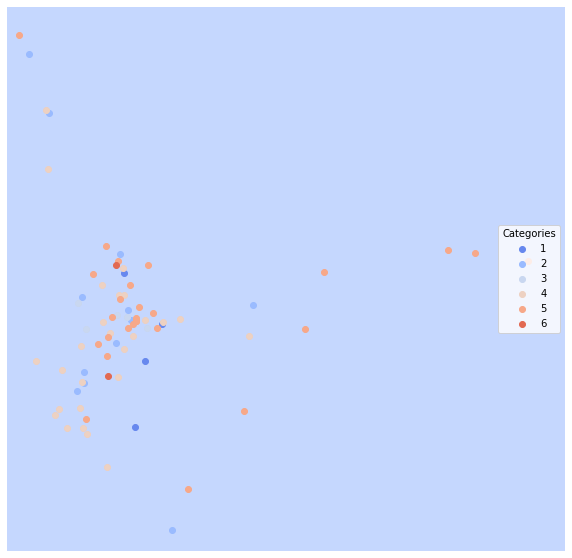

/Users/itsyuzhou/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/itsyuzhou/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/itsyuzhou/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/itsyuzhou/opt/anaconda3/lib/python3.9/site-packages/sklearn/met

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
2,0.20,0.5,0.0,0.20,0.0
3,0.05,0.5,0.0,0.05,0.0
4,0.20,0.5,0.0,0.20,0.0
5,0.50,0.5,0.5,0.50,1.0
6,0.05,0.5,0.0,0.05,0.0


In [397]:
lucem_illud.plotregions(clf_tree, train_data_df)
lucem_illud.evaluateClassifier(clf_tree, test_data_df)

Decision Tree Performance Analysis:
- My decision tree struggles with minority classes such as irony, fear, and joy, shown by the low precision and recall.
- Also the model seems biased towards predicting comments as neutral, evidenced by a high recall but also a high error rate for neutral

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

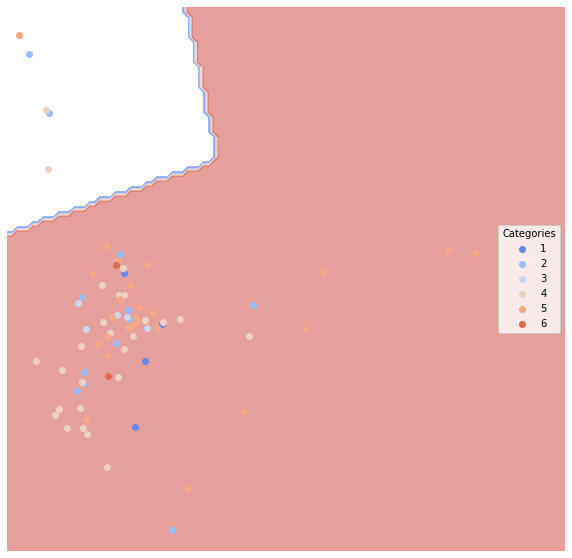

/Users/itsyuzhou/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/itsyuzhou/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
2,0.30,0.43750,0.000000,0.200000,0.0
3,0.05,0.50000,0.000000,0.050000,0.0
4,0.25,0.65625,0.400000,0.300000,0.5
5,0.45,0.55000,0.538462,0.526923,0.7
6,0.05,0.50000,0.000000,0.050000,0.0


In [400]:
clf = sklearn.ensemble.RandomForestClassifier()
clf.fit(np.stack(train_data_df['vect'], axis =0), train_data_df['category'])
lucem_illud.plotregions(clf, train_data_df)
lucem_illud.evaluateClassifier(clf, test_data_df)

- Classifications for sentiments irony, neutral, and anger are moderate using random forest
- In general, we see an improvement for multi-class classfication using random forest compared to decision tree
- Random Forest’s ability to aggregate the insights of multiple decision trees allows it to capture complex patterns in the data without as much risk of overfitting
- However, random forest still did not perform as ideal as I had hoped, among them the best one seems to be neutral.

In [404]:
# Extrapolate
extrapolate_sample = extrapolate_sample = abc_df.sample(n=157, random_state=12)

TFVects = TFVectorizer.fit_transform(extrapolate_sample['Comment'])
extrapolate_sample['vect'] = [np.array(v).flatten() for v in TFVects.todense()]
pca = sklearn.decomposition.PCA()
reduced_data = pca.fit_transform(np.stack(extrapolate_sample['vect'], axis=0))
extrapolate_sample['pca'] = [r for r in reduced_data]

pca_features = np.stack(extrapolate_sample['pca'], axis=0)
extrapolate_sample['Predicted_Sentiment'] = clf.predict(pca_features)
extrapolate_sample.head()

,Comment,Video PublishedAt,tokenized_text,normalized_text,vect,pca,Predicted_Sentiment
7623,Yeah so glad this idiot won,10,"[Yeah, so, glad, this, idiot, won]","[yeah, glad, idiot, won]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.8083896432021676, 0.09298160066777074, 0.04...",4
8834,Regeneron is made from fetal stem cells. So i...,10,"[Regeneron, is, made, from, fetal, stem, cells...","[regeneron, fetal, stem, cells, trump, quot;pr...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.03632995557990094, -0.010925151553186128, ...",5
10522,Hey World read Psalm 91 and meditate on it day...,02,"[Hey, World, read, Psalm, 91, and, meditate, o...","[hey, world, read, psalm, meditate, day, night]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.027262361357782608, -0.058759890577313456,...",5
6764,Too bad Americans in there 20s don&#39;t have ...,03,"[Too, bad, Americans, in, there, 20s, don&#39;...","[bad, americans, 20s, don&#39;t, maturity, sto...","[0.0, 0.0, 0.0, 0.7241737041182068, 0.0, 0.0, ...","[-0.033261408831725695, -0.09360107292547143, ...",5
6608,The country that got it really right? Taiwan.,03,"[The, country, that, got, it, really, right, T...","[country, got, right, taiwan]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.03203773418502877, -0.038929355234237434, ...",4


In [405]:
print(extrapolate_sample.iloc[3]['Comment'])
print(extrapolate_sample.iloc[3]['Predicted_Sentiment'])

Too bad Americans in there 20s don&#39;t have the maturity to stop partying.
5


This comment is correctly classified as neutral

In [406]:
print(extrapolate_sample.iloc[13]['Comment'])
print(extrapolate_sample.iloc[13]['Predicted_Sentiment'])

@@featherknife4786 You are the same type of person who allows Communists dictators to rise to power.
4


This comment is correctly classfied as anger

In [407]:
print(extrapolate_sample.iloc[23]['Comment'])
print(extrapolate_sample.iloc[23]['Predicted_Sentiment'])

...AND, the death rate continues to fall. Idiots.
4


This one also is correctly classified as anger

/Users/itsyuzhou/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


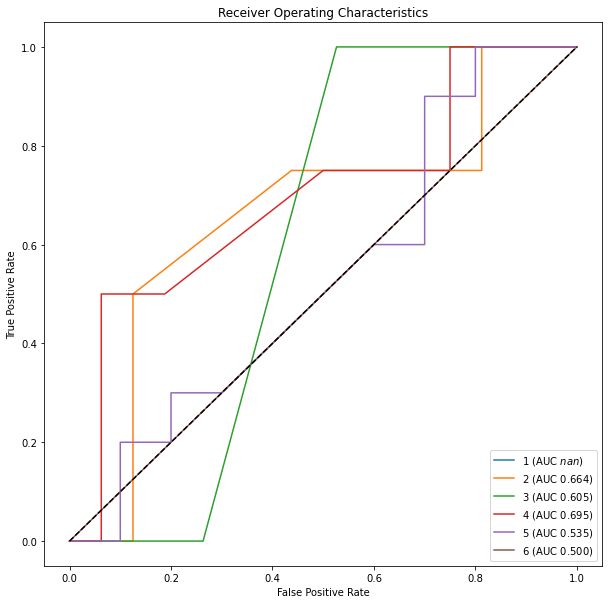

In [415]:
lucem_illud.plotMultiROC(clf, test_data_df)

# K-Nearest Neighbors

The K-Nearest neighbors classifier takes a simpler premise than those before: Find the closest labeled datapoint in set and "borrow" its label.

Let's use newsgroup data.

In [ ]:
newsgroups = sklearn.datasets.fetch_20newsgroups(data_home = '../data') #Free data to play with: documents from a newsgroup corpus. # replace path if on Colab
newsgroups.target_names #Possible categories, i.e., the newsgroups

target_categories = ['talk.religion.misc', 'soc.religion.christian', 'sci.space', 'comp.graphics'] #Can change these of course

newsgroupsDF = pandas.DataFrame(columns = ['text', 'category', 'source_file'])
for category in target_categories:
    print("Loading data for: {}".format(category))
    ng = sklearn.datasets.fetch_20newsgroups(categories = [category], remove=['headers', 'footers', 'quotes'], data_home = '../data')
    newsgroupsDF = newsgroupsDF.append(pandas.DataFrame({'text' : ng.data, 'category' : [category] * len(ng.data), 'source_file' : ng.filenames}), ignore_index=True)

newsgroupsDF['tokenized_text'] = newsgroupsDF['text'].apply(lambda x: lucem_illud.word_tokenize(x))
newsgroupsDF['normalized_text'] = newsgroupsDF['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x))

In [ ]:
newsgroupsDF[:5]

Make a testing and training set:

In [ ]:
holdBackFraction = .2
train_ng_df, test_ng_df = sklearn.model_selection.train_test_split(newsgroupsDF, test_size=holdBackFraction)

Let's initialize our k-nearest neighbors classifier:

In [ ]:
n_neighbors = 15
weights="uniform"
clf_knearest = sklearn.neighbors.KNeighborsClassifier(n_neighbors, weights=weights)

Let's try to classify using the TF-IDF vectors:

In [ ]:
TFVectorizer_ng = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects_ng = TFVectorizer_ng.fit_transform(train_ng_df['text'])
train_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_ng.todense()]

In [ ]:
clf_knearest.fit(np.stack(train_ng_df['vect'], axis = 0), train_ng_df['category'])

In [ ]:
lucem_illud.evaluateClassifier(clf_knearest, train_ng_df)

And lets look at the testing data

In [ ]:
#Create vectors
TFVects_test = TFVectorizer_ng.transform(test_ng_df['text'])
test_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#Add to df
test_ng_df['nb_predict'] = clf_knearest.predict(np.stack(test_ng_df['vect'], axis=0))

#Test
print("Testing score:")
print(clf_knearest.score(np.stack(test_ng_df['vect'], axis=0), test_ng_df['category']))

Let's produce another confusion matrix:

In [ ]:
lucem_illud.plotConfusionMatrix(clf_knearest, test_ng_df)

You can produce the PCA space visual if you want, altough it can take a very long time, so we'll leave it optionally commented out:

In [ ]:
#lucem_illud.plotregions(clf_knearest, test_ng_df)

## <font color="red">*Exercise 5*</font>

<font color="red">In the cells immediately following, perform and visualize k-nearest neighbor classification using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project. Visualize the classification of data points and calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). Articulate how the *k*-nearest neighbor approach relates to *k*-means clustering explored in ***week 3***?

In [408]:
holdBackFraction = .2
train_ng_df, test_ng_df = sklearn.model_selection.train_test_split(abc_wlabel, test_size=holdBackFraction)

In [409]:
n_neighbors = 5
weights="uniform"
clf_knearest = sklearn.neighbors.KNeighborsClassifier(n_neighbors, weights=weights)

In [410]:
TFVectorizer_ng = sklearn.feature_extraction.text.TfidfVectorizer(max_df=4, min_df=2, stop_words='english', norm='l2')
TFVects_ng = TFVectorizer_ng.fit_transform(train_ng_df['Comment'])
train_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_ng.todense()]

In [411]:
clf_knearest.fit(np.stack(train_ng_df['vect'], axis = 0), train_ng_df['category'])

lucem_illud.evaluateClassifier(clf_knearest, train_ng_df)

/Users/itsyuzhou/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/itsyuzhou/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/itsyuzhou/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
1,0.0250,0.500000,0.000000,0.025000,0.000000
2,0.1500,0.571429,1.000000,0.292857,0.142857
3,0.0500,0.500000,0.000000,0.050000,0.000000
4,0.3125,0.764151,0.519231,0.519231,1.000000
5,0.0625,0.919355,1.000000,0.901210,0.838710
6,0.0250,0.500000,0.000000,0.025000,0.000000


KNN Result Interpretation:
- Irony: Moderate error rate (0.15) with higher AUC (0.571429), suggesting some ability to distinguish irony. The precision is perfect (1.0), meaning all predictions for irony are correct, but recall is low (0.142857), indicating the model identifies a small fraction of actual irony cases.
- Sadness and fear both have low error rate (0.025 and 0.005) but with AUC both at 0.5, precision at 0, and recall at 0, indicating the model rarely misclassifies other categories as sadness or fear but also fails to correctly identify sadness and fear.
- Anger: Higher error rate (0.3125) but with the highest AUC (0.764151) among categories, indicating a good ability to distinguish anger. 
- Neutral: Low error rate (0.0625) with very high AUC (0.919355), indicating excellent performance in distinguishing neutral comments. 
- Overall, KNN performs better than logistic regression, decision tree, and random forest in my case

In [413]:
TFVects_test = TFVectorizer_ng.transform(test_ng_df['Comment'])
test_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]
test_ng_df['nb_predict'] = clf_knearest.predict(np.stack(test_ng_df['vect'], axis=0))

print("Testing score:")
print(clf_knearest.score(np.stack(test_ng_df['vect'], axis=0), test_ng_df['category']))

Testing score:
0.4


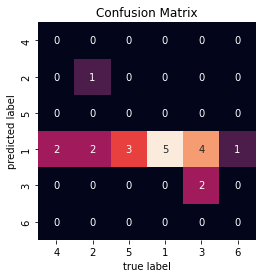

In [414]:
lucem_illud.plotConfusionMatrix(clf_knearest, test_ng_df)

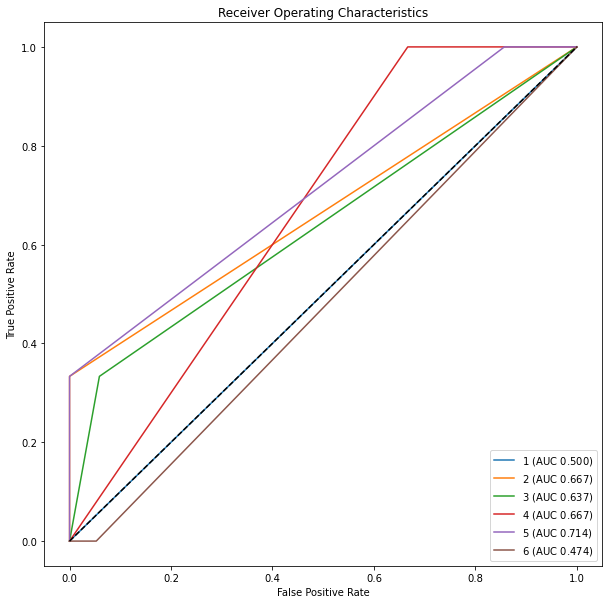

In [416]:
lucem_illud.plotMultiROC(clf_knearest, test_ng_df)

Based on my observatios, K-Nearest Neighbors and K-Means clustering both use the concept of 'k' and refer to the number of neighbors or clusters. However, KNN from this week is a supervised learning model used for classification tasks (classifies comments into sentiment categories based on the features extracted from those comments) by identifying the 'k' training samples closest in distance to a new point and predicts the label based on the majority vote among these 'k' nearest neighbors. K-Means, on the other hand, is an unsupervised learning algorithm used to partition the dataset into 'k' clusters, so that it can help me uncover what potential grouping can be formed without any true labels.

# SVMs

Now we will examine Support Vector Machines, an approach that creates the partition that preserves the "maximum margin" between classes.

We will use a few sub forums from reddit--which tend to share text rather than memes--namely `talesfromtechsupport`, `badroommates`, `weeabootales` and `relationships`. The top 100 text posts from each have been saved to `data/reddit.csv`.

In [ ]:
redditDf = pandas.read_csv('../data/reddit.csv', index_col = 0) # replace path if on Colab

#Drop a couple missing values

redditDf = redditDf.dropna()

#Set category

redditDf['category'] = redditDf['subreddit']

#tokenize and normalize
redditDf['tokenized_text'] = redditDf['text'].apply(lambda x: lucem_illud.word_tokenize(x))
redditDf['normalized_text'] = redditDf['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x))

We will tf.idf the data to make our vectors:

In [ ]:
redditTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, min_df=3, stop_words='english', norm='l2')
redditTFVects = redditTFVectorizer.fit_transform([' '.join(l) for l in redditDf['normalized_text']])
redditDf['vect'] = [np.array(v).flatten() for v in redditTFVects.todense()]

Initilize the model and make a train test split:

In [ ]:
holdBackFraction = .2
train_redditDf, test_redditDf = sklearn.model_selection.train_test_split(redditDf, test_size=holdBackFraction)

In [ ]:
clf_svm = sklearn.svm.SVC(kernel='linear', probability = False)
#probability = True is slower but  lets you call predict_proba()
clf_svm.fit(np.stack(train_redditDf['vect'], axis=0), train_redditDf['category'])

...and consider the results:

In [ ]:
lucem_illud.evaluateClassifier(clf_svm, test_redditDf)

In [ ]:
lucem_illud.plotConfusionMatrix(clf_svm, test_redditDf)

In [ ]:
lucem_illud.plotregions(clf_svm, test_redditDf)

# Neural Nets

We include an example of a simple neural network, the Multi-layer Perceptron (MLP) that learns a function $f(\cdot): R^m \rightarrow R^o$ by training on a dataset, where $m$ is the number of dimensions for input and $o$ is the number of dimensions for output. Given a set of features $X = {x_1, x_2, ..., x_m}$ and a target $y$, it can learn a non-linear function approximator for either classification or regression. It is different from logistic regression, in that between the input and the output layer, there can be one or more non-linear layers, called hidden layers. The following figure shows a one hidden layer MLP with scalar output. The leftmost layer, known as the input layer, consists of a set of "neurons" $\{x_i | x_1, x_2, ..., x_m\}$ representing the input features (e.g., weighted words). Each neuron in the hidden layer transforms the values from the previous layer with a weighted linear summation $z = w_1x_1 + w_2x_2 + ... + w_mx_m$, followed by a non-linear activation function $f(\cdot):R \rightarrow R$ - like the logistic or hyperbolic tan function. The output layer receives the values from the last hidden layer and transforms them into output values.

<img src="https://github.com/UChicago-Computational-Content-Analysis/Homework-Notebooks-2024-Winter/blob/main/data/MLP.jpg?raw=true" alt="https://github.com/UChicago-Computational-Content-Analysis/Homework-Notebooks-2024-Winter/blob/main/data/MLP.jpg?raw=true" style="width:500px">

In [ ]:
clf_nn = sklearn.neural_network.MLPClassifier()
clf_nn.fit(np.stack(train_redditDf['vect'], axis=0), train_redditDf['category'])

In [ ]:
lucem_illud.evaluateClassifier(clf_nn, test_redditDf)

In [ ]:
lucem_illud.plotConfusionMatrix(clf_nn, test_redditDf)

In [ ]:
lucem_illud.plotregions(clf_nn, test_redditDf)

It performs very well.

## <font color="red">*Exercise 6*</font>

<font color="red">In the cells immediately following, perform a neural network classification and calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). How does this classify relevant to *k*-nearest neighbor, logistic and decision-tree approaches?

In [417]:
# train_ng_df, test_ng_df

clf_nn = sklearn.neural_network.MLPClassifier()
clf_nn.fit(np.stack(train_ng_df['vect'], axis=0), train_ng_df['category'])

/Users/itsyuzhou/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier()

In [418]:
lucem_illud.evaluateClassifier(clf_nn, test_ng_df)

/Users/itsyuzhou/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
1,0.10,0.500000,0.000000,0.100000,0.000000
2,0.15,0.637255,0.500000,0.266667,0.333333
3,0.20,0.470588,0.000000,0.150000,0.000000
4,0.50,0.466667,0.222222,0.238889,0.400000
5,0.25,0.726190,0.571429,0.480952,0.666667
6,0.10,0.473684,0.000000,0.050000,0.000000


Evaluate MLP performance:
- Irony has an AUC of 0.637255, indicating a decent ability to distinguish irony from not irony
- Anger has an AUC of 0.726190, indicating a pretty good ability to distinguish anger from non anger
- Overall, the best classfication using MLP seems to be anger

Comparison:
- KNN performs better than both logistic regression and decision tree & random forest
- Both KNN and MLP show variable performance across different categories. However, MLP seems to struggle more with certain categories (e.g., sadness, fear, joy) where it fails to identify any positive cases correctly.
- The AUC values for MLP are generally lower than those for KNN, particularly for categories like fear, anger, and joy. This suggests that MLP, in this configuration, is less effective at distinguishing between positive and negative instances of these sentiments.

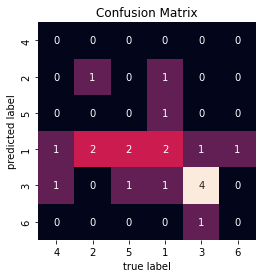

In [419]:
lucem_illud.plotConfusionMatrix(clf_nn, test_ng_df)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

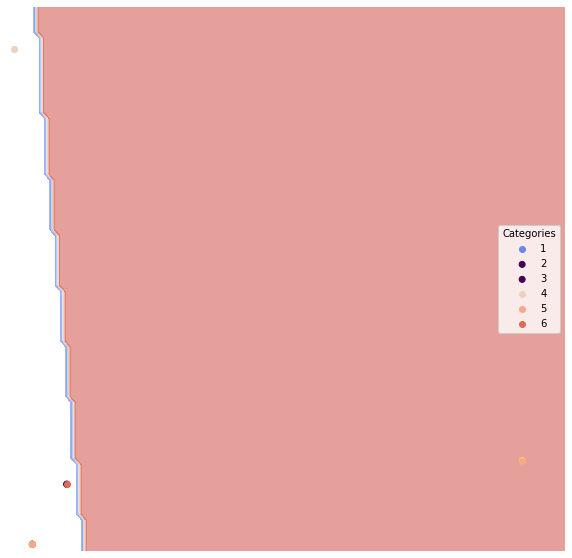

In [420]:
lucem_illud.plotregions(clf_nn, test_ng_df)

## Classification with BERT Pipelines
Now, instead of classifying based on "old" NLP methods, we will now use the popular Transformers package default 'pipelines'. This package has methods for a wide range of common NLP tasks using contextual word embeddings. Note that for this homework, we are not building new contextual models ourselves, merely using existing models in Transformers. We will spend Weeks 7 and 8 learning more about Transformers, so do not worry about fully understanding them this week.

[Transformers Documentation](https://huggingface.co/transformers/)

[Transformers GitHub](https://github.com/huggingface/transformers)

The following sections of code are taken from the [Summary of Tasks](https://huggingface.co/transformers/task_summary.html) page in the Transformers documentation.

### Sequence Classification (e.g., sentiment)
Sequence classification is the task of classifying sequences according to a given number of classes. An example of
sequence classification is the GLUE dataset. If you would like to fine-tune a
model on a GLUE sequence classification task, you may leverage the [pytorch version run_glue.py](https://github.com/huggingface/transformers/blob/f40b87de0ca234df61f76928956c4a2118c0b548/examples/pytorch/text-classification/run_glue.py) and
[pytorch-lightning version run_glue.py](https://github.com/huggingface/transformers/blob/f40b87de0ca234df61f76928956c4a2118c0b548/examples/legacy/pytorch-lightning/run_glue.py)(legacy) or
[tensorflow version run_glue.py](https://github.com/huggingface/transformers/blob/f40b87de0ca234df61f76928956c4a2118c0b548/examples/tensorflow/text-classification/run_glue.py) scripts.

Here is an example of using pipelines to do sentiment analysis: identifying if a sentence is positive or negative. It
leverages a fine-tuned model on sst2, which is a GLUE task.

This returns a label ("POSITIVE" or "NEGATIVE") alongside a score, as follows:

In [431]:
from transformers import pipeline
nlp = pipeline("sentiment-analysis")
result = nlp("I hate you")[0]
print(f"label: {result['label']}, with score: {round(result['score'], 4)}")
result = nlp("I love you")[0]
print(f"label: {result['label']}, with score: {round(result['score'], 4)}")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


RuntimeError: At least one of TensorFlow 2.0 or PyTorch should be installed. To install TensorFlow 2.0, read the instructions at https://www.tensorflow.org/install/ To install PyTorch, read the instructions at https://pytorch.org/.

Here is an example of doing a sequence classification using a model to determine if two sequences are paraphrases of
each other. The process is the following:

1. Instantiate a tokenizer and a model from the checkpoint name. The model is identified as a BERT model and loads it
   with the weights stored in the checkpoint.
2. Build a sequence from the two sentences, with the correct model-specific separators token type ids and attention
   masks (`PreTrainedTokenizer.encode` and `PreTrainedTokenizer.__call__` take
   care of this).
3. Pass this sequence through the model so that it is classified in one of the two available classes: 0 (not a
   paraphrase) and 1 (is a paraphrase).
4. Compute the softmax of the result to get probabilities over the classes.
5. Print the results.

In [432]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased-finetuned-mrpc")
model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased-finetuned-mrpc")
classes = ["not paraphrase", "is paraphrase"]
sequence_0 = "The company HuggingFace is based in New York City"
sequence_1 = "Apples are especially bad for your health"
sequence_2 = "HuggingFace's headquarters are situated in Manhattan"
paraphrase = tokenizer(sequence_0, sequence_2, return_tensors="pt")
not_paraphrase = tokenizer(sequence_0, sequence_1, return_tensors="pt")
paraphrase_classification_logits = model(**paraphrase).logits
not_paraphrase_classification_logits = model(**not_paraphrase).logits
paraphrase_results = torch.softmax(paraphrase_classification_logits, dim=1).tolist()[0]
not_paraphrase_results = torch.softmax(not_paraphrase_classification_logits, dim=1).tolist()[0]
# Should be paraphrase
for i in range(len(classes)):
    print(f"{classes[i]}: {int(round(paraphrase_results[i] * 100))}%")
# Should not be paraphrase
for i in range(len(classes)):
    print(f"{classes[i]}: {int(round(not_paraphrase_results[i] * 100))}%")

ImportError: 
AutoModelForSequenceClassification requires the PyTorch library but it was not found in your environment. Checkout the instructions on the
installation page: https://pytorch.org/get-started/locally/ and follow the ones that match your environment.
Please note that you may need to restart your runtime after installation.


### Extractive Question Answering

Extractive Question Answering is the task of extracting an answer from a text given a question. An example of a
question answering dataset is the SQuAD dataset, which is entirely based on that task. If you would like to fine-tune a
model on a SQuAD task, you may leverage the [run_squad.py](https://github.com/huggingface/transformers/blob/f40b87de0ca234df61f76928956c4a2118c0b548/examples/legacy/question-answering/run_squad.py) (legacy) script.


Here is an example of using pipelines to do question answering: extracting an answer from a text given a question. It
leverages a fine-tuned model on SQuAD.

In [426]:
from transformers import pipeline
nlp = pipeline("question-answering")
context = r"""
Extractive Question Answering is the task of extracting an answer from a text given a question. An example of a
question answering dataset is the SQuAD dataset, which is entirely based on that task. If you would like to fine-tune
a model on a SQuAD task, you may leverage the examples/legacy/question-answering/run_squad.py
"""

No model was supplied, defaulted to distilbert-base-cased-distilled-squad and revision 626af31 (https://huggingface.co/distilbert-base-cased-distilled-squad).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/473 [00:00<?, ?B/s]

RuntimeError: At least one of TensorFlow 2.0 or PyTorch should be installed. To install TensorFlow 2.0, read the instructions at https://www.tensorflow.org/install/ To install PyTorch, read the instructions at https://pytorch.org/.

This returns an answer extracted from the text, a confidence score, alongside "start" and "end" values, which are the
positions of the extracted answer in the text.

In [ ]:
result = nlp(question="What is extractive question answering?", context=context)
print(f"Answer: '{result['answer']}', score: {round(result['score'], 4)}, start: {result['start']}, end: {result['end']}")
result = nlp(question="What is a good example of a question answering dataset?", context=context)
print(f"Answer: '{result['answer']}', score: {round(result['score'], 4)}, start: {result['start']}, end: {result['end']}")

Here is an example of question answering using a model and a tokenizer. The process is the following:

1. Instantiate a tokenizer and a model from the checkpoint name. The model is identified as a BERT model and loads it
   with the weights stored in the checkpoint.
2. Define a text and a few questions.
3. Iterate over the questions and build a sequence from the text and the current question, with the correct
   model-specific separators token type ids and attention masks.
4. Pass this sequence through the model. This outputs a range of scores across the entire sequence of tokens (question and
   text), for both the start and end positions.
5. Compute the softmax of the result to get probabilities over the tokens.
6. Fetch the tokens from the identified start and stop values, convert those tokens to a string.
7. Print the results.

In [ ]:
from transformers import AutoTokenizer, AutoModelForQuestionAnswering
import torch
tokenizer = AutoTokenizer.from_pretrained("bert-large-uncased-whole-word-masking-finetuned-squad")
model = AutoModelForQuestionAnswering.from_pretrained("bert-large-uncased-whole-word-masking-finetuned-squad")
text = r"""
🤗 Transformers (formerly known as pytorch-transformers and pytorch-pretrained-bert) provides general-purpose
architectures (BERT, GPT-2, RoBERTa, XLM, DistilBert, XLNet…) for Natural Language Understanding (NLU) and Natural
Language Generation (NLG) with over 32+ pretrained models in 100+ languages and deep interoperability between
TensorFlow 2.0 and PyTorch.
"""
questions = [
    "How many pretrained models are available in 🤗 Transformers?",
    "What does 🤗 Transformers provide?",
    "🤗 Transformers provides interoperability between which frameworks?",
]
for question in questions:
    inputs = tokenizer(question, text, add_special_tokens=True, return_tensors="pt")
    input_ids = inputs["input_ids"].tolist()[0]

    text_tokens = tokenizer.convert_ids_to_tokens(input_ids)
    outputs = model(**inputs)
    answer_start_scores = outputs.start_logits
    answer_end_scores = outputs.end_logits

    answer_start = torch.argmax(
        answer_start_scores
    )  # Get the most likely beginning of answer with the argmax of the score
    answer_end = torch.argmax(answer_end_scores) + 1  # Get the most likely end of answer with the argmax of the score

    answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(input_ids[answer_start:answer_end]))

    print(f"Question: {question}")
    print(f"Answer: {answer}")

## <font color="red">*Exercise 7*</font>

<font color="red">In the cells immediately following, use the pipeline functions or the word or sentence vector functions (e.g., similarity) to explore the social game underlying the production and meaning of texts associated with your final project. How does BERT help you gain insight regarding your research question that is similar and different from prior methods?

### 1. Sentiment analysis on some YouTube comments

In [428]:
sample_comments = abc_df['Comment'].sample(n=10, random_state=42).tolist()
sample_comments

['South Korea has to put these precautions in place, China is too close !!!! Trump 2020 🇺🇸🇺🇸🇺🇸',
 'Vaccine Mandates? He will go to mayors, governors, council members?',
 'Not to give credit but we actually have no idea of how many are infected due to inadequate testing.',
 'nothing but to wait for his 2 rotten eggs to hatch!',
 '@NewtNukem you said it dude. Which means S.K has much bigger population in the same measurement of province.',
 'He is too frail, won´t last long.',
 'GOD SAID, PRAY FOR THOSE IN. GOVERNMENT.<br>I GUESS IT&#39;S FOR US TO HAVE <br>LAW AND ORDER.<br>WE PRAY FOR THE QUEEN.<br>I KNOW SHE LOVES HER FAMILY<br>TOO!',
 'For some the truth hurts, sadly the government is bringing America down the slope 😬',
 'TRUMP alone can fix this.',
 'Thats fucked up']

In [ ]:
def sentiment_analysis(comment_lst):
    nlp = pipeline("sentiment-analysis")
    for comment in comment_lst:
        result = nlp(comment)[0]
        print(f"label: {result['label']}, with score: {round(result['score'], 4)}")

sentiment_analysis(sample_comments)

In [429]:
long_comments_df = abc_df[abc_df['Comment'].apply(lambda x: len(x.split()) > 30)]
sample_long_comments = long_comments_df['Comment'].sample(n=10, random_state=42).tolist()
print(sample_long_comments)

['From what I have heard, this is false. The situation is worse and the right-wing is suppressing information. I can only say this as a US citizen with family in Korea.', 'I’m Korean. Wearing a mask all day long is very uncomfortable:-( it hurts my ears and it’s hard to breathe. But i WEAR a mask because i dont want to get infected and i care about my family and friends. wear a mask 😷', 'BeardedDragonHQ , the ignorance is when they spread the disease to the people that are caring and smart enough not to gather in numbers, but obviously you are ok with them killing innocent people, go figure!', 'By your logic, the death rate of 9/11 dropped by 100% the very next day, so why did Americans care for so long about that little event that only killed a fraction of US Covid-19 deaths so far?', 'Everyone will be infected, if they’re tested. I call bullshit. Just like you reported on Michigan 2 months ago, it wasn’t over flowing! It was all lies then, I’m sure it is now! Flu still kills 5 times 

In [430]:
for comment in sample_long_comments:
    print(comment)

From what I have heard, this is false. The situation is worse and the right-wing is suppressing information. I can only say this as a US citizen with family in Korea.
I’m Korean. Wearing a mask all day long is very uncomfortable:-( it hurts my ears and it’s hard to breathe. But i WEAR a mask because i dont want to get infected and i care about my family and friends. wear a mask 😷
BeardedDragonHQ , the ignorance is when they spread the disease to the people that are caring and smart enough not to gather in numbers, but obviously you are ok with them killing innocent people, go figure!
By your logic, the death rate of 9/11 dropped by 100% the very next day, so why did Americans care for so long about that little event that only killed a fraction of US Covid-19 deaths so far?
Everyone will be infected, if they’re tested. I call bullshit. Just like you reported on Michigan 2 months ago, it wasn’t over flowing! It was all lies then, I’m sure it is now! Flu still kills 5 times more!
Governme

In [433]:
nlp = pipeline("question-answering")
context = r"""
From what I have heard, this is false. The situation is worse and the right-wing 
is suppressing information. I can only say this as a US citizen with family in Korea.
"""

result = nlp(question="How is the situation?", context=context)
print(f"Answer: '{result['answer']}', score: {round(result['score'], 4)}, start: {result['start']}, end: {result['end']}")

No model was supplied, defaulted to distilbert-base-cased-distilled-squad and revision 626af31 (https://huggingface.co/distilbert-base-cased-distilled-squad).
Using a pipeline without specifying a model name and revision in production is not recommended.


RuntimeError: At least one of TensorFlow 2.0 or PyTorch should be installed. To install TensorFlow 2.0, read the instructions at https://www.tensorflow.org/install/ To install PyTorch, read the instructions at https://pytorch.org/.

In [ ]:
context = r"""
BeardedDragonHQ , the ignorance is when they spread the disease to the people that 
are caring and smart enough not to gather in numbers, but obviously you are ok with 
them killing innocent people, go figure!
"""

result = nlp(question="What is the ignorance?", context=context)
print(f"Answer: '{result['answer']}', score: {round(result['score'], 4)}, start: {result['start']}, end: {result['end']}")

In [ ]:
context = r"""
Despite the testing..........  It's because of all of the testing.  
You cannot over exposed the PRC test more than 30 times these idiots are doing it 
40 times Dr. Fouchi. says you can't do that
"""

result = nlp(question="What is the attitude toward testing?", context=context)
print(f"Answer: '{result['answer']}', score: {round(result['score'], 4)}, start: {result['start']}, end: {result['end']}")